# Analysis for IndeLLM 

This notebook shows the analysis as well as creating of the main and supplementary figures for section 4.1, 4.2 and 4.3 prestented in the article. 

# Imports

First, we imported all the datasets: Indels_Full (extended dataset with 7563 indels). We also do analysis on dataset splits (Cannon et al. subset with scores from nine predictions tools for 3478 indels, and the training, Validation and Test datasets).

Second, we imported all the resulting scores from the 8 different PLM runs. All the scoring tables include Brandes and IndeLLM scores for the wildtype and mutated sequences, as well as the precomputed IndeLLM filtered score.   


In [1]:
import pandas as pd

#Import datasets
alldata = pd.read_csv("../Data/Indels_Full.csv")
Cannonetal = pd.read_csv("../Data/Indels_Cannonetal.csv")
train = pd.read_csv("../Data/train.csv")
val = pd.read_csv("../Data/val.csv")
test = pd.read_csv("../Data/test.csv")

#import scores per PLM
scoresESM1b = pd.read_csv("../Data/scores_ESM1b.csv")
scoresESM1v = pd.read_csv("../Data/scores_ESM1v.csv")
scoresESM2_3B = pd.read_csv("../Data/scores_ESM2_3B.csv")
scoresESM2_150M = pd.read_csv("../Data/scores_ESM2_150M.csv")
scoresESM2_650M = pd.read_csv("../Data/scores_ESM2_650M.csv")
scoresESM2_650M_masked = pd.read_csv("../Data/scores_ESM2_650M_masked.csv")
scoresESM3 = pd.read_csv("../Data/scores_ESM3.csv")
scoresProtTrans = pd.read_csv("../Data/scores_ProtTrans.csv")

/tmp/ipykernel_1719985/817179385.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Section 4.1 Efficient scoring approach for zero-shot inference using PLMs
To find the efficient scoring approach we opted to use the scores from ESM2 650M parameters. 

From the resulting scores we need to substract the wildtype score from the mutation score for find the IndeLLM, IndeLLM masked and Brandes scores for each indel. 
We used the aboslute number for IndeLLM abd and Brandes abs. IndeLLM filtered are precomputed in each scoring table. (See script ### for calcualtions)

In [24]:
scoresESM2_650M['dif_IndeLLM'] = scoresESM2_650M['IndeLLM_mut'] - scoresESM2_650M['IndeLLM_wt'] # IndeLLM
scoresESM2_650M['dif_IndeLLM_abs'] = abs(scoresESM2_650M['IndeLLM_mut'] - scoresESM2_650M['IndeLLM_wt']) # IndeLLM abs
scoresESM2_650M_masked['dif_IndeLLM'] = scoresESM2_650M_masked['IndeLLM_mut'] - scoresESM2_650M_masked['IndeLLM_wt'] # IndeLLM masked
scoresESM2_650M['dif_Brandes'] = scoresESM2_650M['Brandes_mut'] - scoresESM2_650M['Brandes_wt'] # Brandes
scoresESM2_650M['dif_Brandes_abs'] = abs(scoresESM2_650M['Brandes_mut'] - scoresESM2_650M['Brandes_wt']) # Brandes abs

### Performace analysis of scoring approaches
We evaluate the performace of the scoring approaches by calculation of false and true positives, AUC, F1-score and MCC.

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import metrics
from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix

truelabels_alldata = alldata['label'].values 

pred_ESM2650M_IndeLLM = scoresESM2_650M['dif_IndeLLM'].values
pred_ESM2650M_IndeLLM_filtered = scoresESM2_650M['IndeLLM_filtered'].values
pred_ESM2650M_IndeLLM_abs = scoresESM2_650M['dif_IndeLLM_abs'].values
pred_ESM2650M_masked_IndeLLM = scoresESM2_650M_masked['dif_IndeLLM'].values
pred_ESM2650M_Brandes = scoresESM2_650M['dif_Brandes'].values
pred_ESM2650M_Brandes_abs = scoresESM2_650M['dif_Brandes_abs'].values

fpr_ESM2650M_IndeLLM, tpr_ESM2650M_IndeLLM, thersholds_ESM2650M_IndeLLM = metrics.roc_curve(truelabels_alldata, pred_ESM2650M_IndeLLM, pos_label=0)
fpr_ESM2650M_IndeLLM_filtered, tpr_ESM2650M_IndeLLM_filtered, thersholds_ESM2650M_IndeLLM_filtered = metrics.roc_curve(truelabels_alldata, pred_ESM2650M_IndeLLM_filtered, pos_label=0)
fpr_ESM2650M_IndeLLM_abs, tpr_ESM2650M_IndeLLM_abs, thersholds_ESM2650M_IndeLLM_abs = metrics.roc_curve(truelabels_alldata, pred_ESM2650M_IndeLLM_abs, pos_label=1) #abs scores are flipped
fpr_ESM2650M_masked_IndeLLM, tpr_ESM2650M_masked_IndeLLM, thersholds_ESM2650M_masked_IndeLLM = metrics.roc_curve(truelabels_alldata, pred_ESM2650M_masked_IndeLLM, pos_label=0)
fpr_ESM2650M_Brandes, tpr_ESM2650M_Brandes, thersholds_ESM2650M_Brandes = metrics.roc_curve(truelabels_alldata, pred_ESM2650M_Brandes, pos_label=0)
fpr_ESM2650M_Brandes_abs, tpr_ESM2650M_Brandes_abs, thersholds_ESM2650M_Brandes_abs = metrics.roc_curve(truelabels_alldata, pred_ESM2650M_Brandes_abs, pos_label=1) #abs scors are flipped

roc_auc_ESM2650M_IndeLLM = round(metrics.auc(fpr_ESM2650M_IndeLLM, tpr_ESM2650M_IndeLLM), 2)
roc_auc_ESM2650M_IndeLLM_filtered = round(metrics.auc(fpr_ESM2650M_IndeLLM_filtered, tpr_ESM2650M_IndeLLM_filtered), 2)
roc_auc_ESM2650M_IndeLLM_abs = round(metrics.auc(fpr_ESM2650M_IndeLLM_abs, tpr_ESM2650M_IndeLLM_abs), 2)
roc_auc_ESM2650M_masked_IndeLLM = round(metrics.auc(fpr_ESM2650M_masked_IndeLLM, tpr_ESM2650M_masked_IndeLLM), 2)
roc_auc_ESM2650M_Brandes = round(metrics.auc(fpr_ESM2650M_Brandes, tpr_ESM2650M_Brandes), 2)
roc_auc_ESM2650M_Brandes_abs = round(metrics.auc(fpr_ESM2650M_Brandes_abs, tpr_ESM2650M_Brandes_abs), 2)

tresh_ESM2650M_IndeLLM = thersholds_ESM2650M_IndeLLM[np.argmax(tpr_ESM2650M_IndeLLM - fpr_ESM2650M_IndeLLM)]
tresh_ESM2650M_IndeLLM_filtered = thersholds_ESM2650M_IndeLLM_filtered[np.argmax(tpr_ESM2650M_IndeLLM_filtered - fpr_ESM2650M_IndeLLM_filtered)]
tresh_ESM2650M_IndeLLM_abs = thersholds_ESM2650M_IndeLLM_abs[np.argmax(tpr_ESM2650M_IndeLLM_abs - fpr_ESM2650M_IndeLLM_abs)]
tresh_ESM2650M_masked_IndeLLM = thersholds_ESM2650M_masked_IndeLLM[np.argmax(tpr_ESM2650M_masked_IndeLLM - fpr_ESM2650M_masked_IndeLLM)]
tresh_ESM2650M_Brandes = thersholds_ESM2650M_Brandes[np.argmax(tpr_ESM2650M_Brandes - fpr_ESM2650M_Brandes)]
tresh_ESM2650M_Brandes_abs = thersholds_ESM2650M_Brandes_abs[np.argmax(tpr_ESM2650M_Brandes_abs - fpr_ESM2650M_Brandes_abs)]

pred_ESM2650M_IndeLLM_bin = [0 if x >= tresh_ESM2650M_IndeLLM else 1 for x in pred_ESM2650M_IndeLLM]
pred_ESM2650M_IndeLLM_filtered_bin = [0 if x >= tresh_ESM2650M_IndeLLM_filtered else 1 for x in pred_ESM2650M_IndeLLM_filtered]
pred_ESM2650M_IndeLLM_bin_abs = [1 if x >= tresh_ESM2650M_IndeLLM_abs else 0 for x in pred_ESM2650M_IndeLLM_abs] #binary abs scores are flipped
pred_ESM2650M_masked_IndeLLM_bin = [0 if x >= tresh_ESM2650M_masked_IndeLLM else 1 for x in pred_ESM2650M_masked_IndeLLM]
pred_ESM2650M_Brandes_bin = [0 if x >= tresh_ESM2650M_Brandes else 1 for x in pred_ESM2650M_Brandes]
pred_ESM2650M_Brandes_bin_abs = [1 if x >= tresh_ESM2650M_Brandes_abs else 0 for x in pred_ESM2650M_Brandes_abs] #binary abs scores are flipped

f1_ESM2650M_IndeLLM = f1_score(truelabels_alldata, pred_ESM2650M_IndeLLM_bin, average = 'binary', pos_label=0)
f1_ESM2650M_IndeLLM_filtered = f1_score(truelabels_alldata, pred_ESM2650M_IndeLLM_filtered_bin, average = 'binary', pos_label=0)
f1_ESM2650M_IndeLLM_abs = f1_score(truelabels_alldata, pred_ESM2650M_IndeLLM_bin_abs, average = 'binary', pos_label=0)
f1_ESM2650M_masked_IndeLLM = f1_score(truelabels_alldata, pred_ESM2650M_masked_IndeLLM_bin, average = 'binary', pos_label=0)
f1_ESM2650M_Brandes = f1_score(truelabels_alldata, pred_ESM2650M_Brandes_bin, average = 'binary', pos_label=0)
f1_ESM2650M_Brandes_abs = f1_score(truelabels_alldata, pred_ESM2650M_Brandes_bin_abs, average = 'binary', pos_label=0)

mcc_ESM2650M_IndeLLM = matthews_corrcoef(truelabels_alldata, pred_ESM2650M_IndeLLM_bin)
mcc_ESM2650M_IndeLLM_filtered = matthews_corrcoef(truelabels_alldata, pred_ESM2650M_IndeLLM_filtered_bin)
mcc_ESM2650M_IndeLLM_abs = matthews_corrcoef(truelabels_alldata, pred_ESM2650M_IndeLLM_bin_abs)
mcc_ESM2650M_masked_IndeLLM = matthews_corrcoef(truelabels_alldata, pred_ESM2650M_masked_IndeLLM_bin)
mcc_ESM2650M_Brandes = matthews_corrcoef(truelabels_alldata, pred_ESM2650M_Brandes_bin)
mcc_ESM2650M_Brandes_abs = matthews_corrcoef(truelabels_alldata, pred_ESM2650M_Brandes_bin_abs)

### Plotting of Main Figure 1A-B

/var/folders/5p/q6ym8f8d30bcrz8gjd8ks42h0000gn/T/ipykernel_10716/2067099403.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(fontsize = 8, frameon=False)


Text(0.0, 1.0, 'B) MCC scores for ESM2 650M Scoring methods')

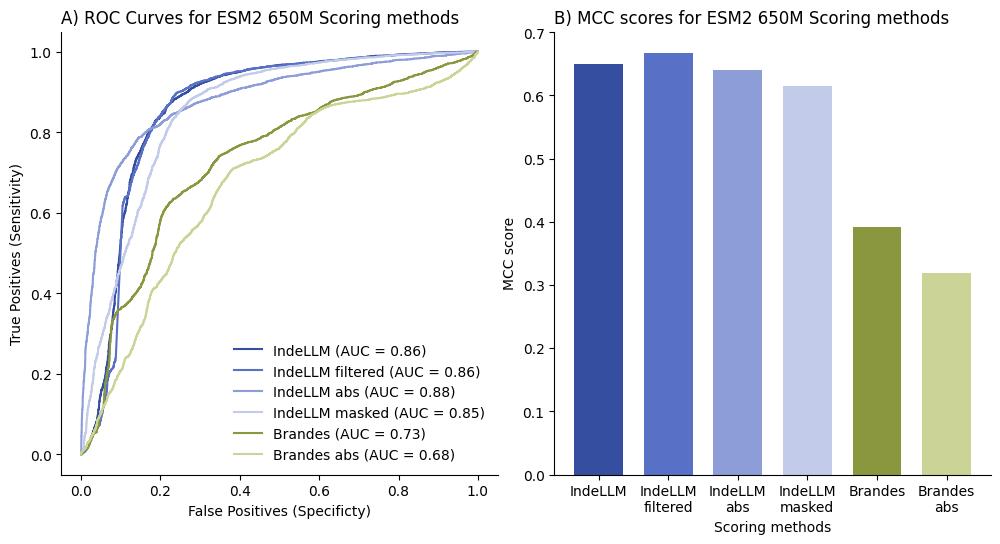

In [26]:

allscores = {'Score': ['IndeLLM', 'IndeLLM filtered', 'IndeLLM abs', 'IndeLLM masked', 'Brandes', 'Brandes abs'],
                 'F1': [f1_ESM2650M_IndeLLM, f1_ESM2650M_IndeLLM_filtered, f1_ESM2650M_IndeLLM_abs, f1_ESM2650M_masked_IndeLLM, f1_ESM2650M_Brandes, f1_ESM2650M_Brandes_abs], 
                 'MCC': [mcc_ESM2650M_IndeLLM, mcc_ESM2650M_IndeLLM_filtered,  mcc_ESM2650M_IndeLLM_abs, mcc_ESM2650M_masked_IndeLLM, mcc_ESM2650M_Brandes, mcc_ESM2650M_Brandes_abs], 
                 'AUC': [roc_auc_ESM2650M_IndeLLM, roc_auc_ESM2650M_IndeLLM_filtered, roc_auc_ESM2650M_IndeLLM_abs, roc_auc_ESM2650M_masked_IndeLLM, roc_auc_ESM2650M_Brandes, roc_auc_ESM2650M_Brandes_abs]}
allscores = pd.DataFrame(allscores)

colors = {
    'IndeLLM': '#364e9f',
    'IndeLLM filtered': '#5870c5',
    'IndeLLM abs': '#8d9dd7',
    'IndeLLM masked': '#C2CBEA',
    'Brandes': '#8a973e',
    'Brandes abs': '#CBD496'
}

scores_label = ['IndeLLM', 'IndeLLM\nfiltered', 'IndeLLM\nabs', 'IndeLLM\nmasked', 'Brandes', 'Brandes\nabs']

n_methods = len(allscores['Score'])
bar_width = 0.7
r1 = np.arange(n_methods)
r2 = [x + bar_width for x in r1]

f, axes = plt.subplots(1,2)
f.set_figheight(5)
f.set_figwidth(10)
f.tight_layout(pad=1)
axes[0].plot(fpr_ESM2650M_IndeLLM, tpr_ESM2650M_IndeLLM, label = "IndeLLM (AUC = "+str(roc_auc_ESM2650M_IndeLLM)+")", color = "#364e9f")
axes[0].plot(fpr_ESM2650M_IndeLLM_filtered, tpr_ESM2650M_IndeLLM_filtered, label = "IndeLLM filtered (AUC = "+str(roc_auc_ESM2650M_IndeLLM_filtered)+")", color = "#5870c5")
axes[0].plot(fpr_ESM2650M_IndeLLM_abs, tpr_ESM2650M_IndeLLM_abs, label = "IndeLLM abs (AUC = "+str(roc_auc_ESM2650M_IndeLLM_abs)+")", color = "#8d9dd7")
axes[0].plot(fpr_ESM2650M_masked_IndeLLM, tpr_ESM2650M_masked_IndeLLM, label = "IndeLLM masked (AUC = "+str(roc_auc_ESM2650M_masked_IndeLLM)+")", color = "#C2CBEA")
axes[0].plot(fpr_ESM2650M_Brandes, tpr_ESM2650M_Brandes, label = "Brandes (AUC = "+str(roc_auc_ESM2650M_Brandes)+")", color = "#8a973e")
axes[0].plot(fpr_ESM2650M_Brandes_abs, tpr_ESM2650M_Brandes_abs, label = "Brandes abs (AUC = "+str(roc_auc_ESM2650M_Brandes_abs)+")", color = "#CBD496")
axes[0].set_xlabel('False Positives (Specificty)')
axes[0].set_ylabel('True Positives (Sensitivity)')
axes[0].set_title("A) ROC Curves for ESM2 650M Scoring methods", loc = 'left')
axes[0].legend(loc = 'best', frameon=False)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[1].bar(r1, allscores['MCC'], color=[colors[score] for score in allscores['Score']], width=bar_width)
axes[1].set_ylabel('MCC score')
axes[1].set_xlabel('Scoring methods')
axes[1].set_xticks(r1, scores_label)
axes[1].legend(fontsize = 8, frameon=False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_title('B) MCC scores for ESM2 650M Scoring methods', loc = 'left')

### Supplement analysis and plotting of Figure S1A-D

We compare the preformance of IndeLLM and Brandes scoring approach by indel type. 
First we split the dataset by indel type (insertion and deletions).
Second we recalcualte the false and true positives to generate confusions matrixes per indel type and scoring approach. 

/var/folders/5p/q6ym8f8d30bcrz8gjd8ks42h0000gn/T/ipykernel_10716/3559716631.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.5, 0.1, 0.5, 0.5])
/var/folders/5p/q6ym8f8d30bcrz8gjd8ks42h0000gn/T/ipykernel_10716/3559716631.py:81: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0.5, 0.1, 0.5, 0.5])


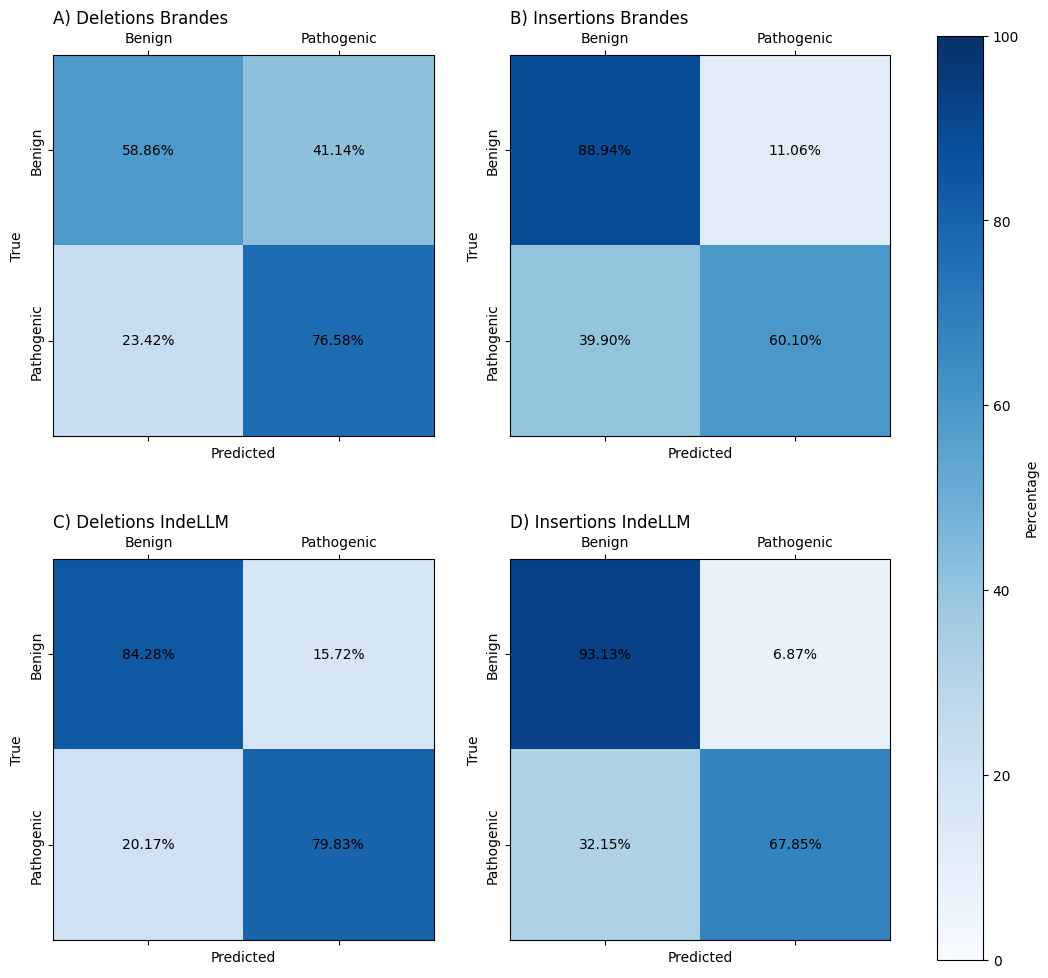

In [27]:
scoresESM2_650M_ins = scoresESM2_650M[scoresESM2_650M['indel_type'] == 'insertion']
scoresESM2_650M_del = scoresESM2_650M[scoresESM2_650M['indel_type'] == 'deletion']

pred_ESM2650M_Brandes_ins = scoresESM2_650M_ins['dif_Brandes'].values
pred_ESM2650M_IndeLLM_ins = scoresESM2_650M_ins['dif_IndeLLM'].values
pred_ESM2650M_Brandes_del = scoresESM2_650M_del['dif_Brandes'].values
pred_ESM2650M_IndeLLM_del = scoresESM2_650M_del['dif_IndeLLM'].values

truelabels_ESM2650M_ins = scoresESM2_650M_ins['label'].values
truelabels_ESM2650M_del = scoresESM2_650M_del['label'].values

fpr_ESM2650M_Brandes_ins, tpr_ESM2650M_Brandes_ins, thersholds_ESM2650M_Brandes_ins = metrics.roc_curve(truelabels_ESM2650M_ins, pred_ESM2650M_Brandes_ins, pos_label=0)
fpr_ESM2650M_IndeLLM_ins, tpr_ESM2650M_IndeLLM_ins, thersholds_ESM2650M_IndeLLM_ins = metrics.roc_curve(truelabels_ESM2650M_ins, pred_ESM2650M_IndeLLM_ins, pos_label=0)
fpr_ESM2650M_Brandes_del, tpr_ESM2650M_Brandes_del, thersholds_ESM2650M_Brandes_del = metrics.roc_curve(truelabels_ESM2650M_del, pred_ESM2650M_Brandes_del, pos_label=0)
fpr_ESM2650M_IndeLLM_del, tpr_ESM2650M_IndeLLM_del, thersholds_ESM2650M_IndeLLM_del = metrics.roc_curve(truelabels_ESM2650M_del, pred_ESM2650M_IndeLLM_del, pos_label=0)

tresh_ESM2650M_Brandes_ins = thersholds_ESM2650M_Brandes_ins[np.argmax(tpr_ESM2650M_Brandes_ins - fpr_ESM2650M_Brandes_ins)]
tresh_ESM2650M_IndeLLM_ins = thersholds_ESM2650M_IndeLLM_ins[np.argmax(tpr_ESM2650M_IndeLLM_ins - fpr_ESM2650M_IndeLLM_ins)]
tresh_ESM2650M_Brandes_del = thersholds_ESM2650M_Brandes_del[np.argmax(tpr_ESM2650M_Brandes_del - fpr_ESM2650M_Brandes_del)]
tresh_ESM2650M_IndeLLM_del = thersholds_ESM2650M_IndeLLM_del[np.argmax(tpr_ESM2650M_IndeLLM_del - fpr_ESM2650M_IndeLLM_del)]

pred_ESM2650M_Brandes_ins_bin = [0 if x >= tresh_ESM2650M_Brandes_ins else 1 for x in pred_ESM2650M_Brandes_ins]
pred_ESM2650M_IndeLLM_ins_bin = [0 if x >= tresh_ESM2650M_IndeLLM_ins else 1 for x in pred_ESM2650M_IndeLLM_ins]
pred_ESM2650M_Brandes_del_bin = [0 if x >= tresh_ESM2650M_Brandes_del else 1 for x in pred_ESM2650M_Brandes_del]
pred_ESM2650M_IndeLLM_del_bin = [0 if x >= tresh_ESM2650M_IndeLLM_del else 1 for x in pred_ESM2650M_IndeLLM_del]

confusion_ESM2650M_Brandes_ins = confusion_matrix(truelabels_ESM2650M_ins, pred_ESM2650M_Brandes_ins_bin)
confusion_ESM2650M_IndeLLM_ins = confusion_matrix(truelabels_ESM2650M_ins, pred_ESM2650M_IndeLLM_ins_bin)
confusion_ESM2650M_Brandes_del = confusion_matrix(truelabels_ESM2650M_del, pred_ESM2650M_Brandes_del_bin)
confusion_ESM2650M_IndeLLM_del = confusion_matrix(truelabels_ESM2650M_del, pred_ESM2650M_IndeLLM_del_bin)


# Define the percentage matrix calculation
def calculate_percentage_matrix(confusion):
    return (confusion.T / confusion.sum(axis=1)).T * 100

# Plot function for each confusion matrix
def plot_percentage_confusion_matrix(confusion, title, labels, ax):
    percentage_matrix = calculate_percentage_matrix(confusion)
    cax = ax.matshow(percentage_matrix, cmap="Blues", vmin=0, vmax=100)

    # Annotate each cell with the percentage value
    for (i, j), value in np.ndenumerate(percentage_matrix):
        ax.text(j, i, f"{value:.2f}%", ha="center", va="center", color="black")

    ax.set_xticks([1, 0])
    ax.set_xticklabels(labels)
    ax.set_yticks([1, 0])
    ax.set_yticklabels(labels, rotation = 90, va='center')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title, loc = 'left')
    
    return cax

# Define labels and titles
labels = ["Pathogenic", "Benign"]
titles = [
    "A) Deletions Brandes",
    "B) Insertions Brandes",
    "C) Deletions IndeLLM",
    "D) Insertions IndeLLM"
]
confusions = [
    confusion_ESM2650M_Brandes_del,
    confusion_ESM2650M_Brandes_ins,
    confusion_ESM2650M_IndeLLM_del,
    confusion_ESM2650M_IndeLLM_ins
]

# Create subplots and plot each confusion matrix
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
# Loop through the subplots and plot each confusion matrix
for ax, confusion, title in zip(axes.ravel(), confusions, titles):
    cax_matrix = plot_percentage_confusion_matrix(confusion, title, labels, ax=ax)

# Add a color bar to the figure
fig.colorbar(cax_matrix, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.05, pad=0.05, label='Percentage')

# Adjust layout for clarity
plt.tight_layout(rect=[0.5, 0.1, 0.5, 0.5])

### Supplement analysis contiuned, Figure S1E-F
We find that IndeLLM has unbalanced confusion matrix for insertions.
We calculated the mean likelihoods of the instered amino acid by substracting the Brandes mutated score from the IndeLLM mutated score (Brandes is the sum of all likelhoods, while IndeLLM is the sum of likehoods of the non-inserted residues). The difference is the values of the inserted residues. Then we use the lenght of the indel to find the mean value of the inserted residues. 

Then we splitt insertion subset by labels (pathogenic and bening) to identify the true and false positives. 

/var/folders/5p/q6ym8f8d30bcrz8gjd8ks42h0000gn/T/ipykernel_10716/440926106.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scoresESM2_650M_ins['mean_inserted'] = (scoresESM2_650M_ins['Brandes_mut'] - scoresESM2_650M_ins['IndeLLM_mut']) / scoresESM2_650M_ins['indel_length']
/var/folders/5p/q6ym8f8d30bcrz8gjd8ks42h0000gn/T/ipykernel_10716/440926106.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scoresESM2_650M_ins['pred_ESM2650M_IndeLLM_ins_bin'] = pred_ESM2650M_IndeLLM_ins_bin
/var/folders/5p/q6ym8f

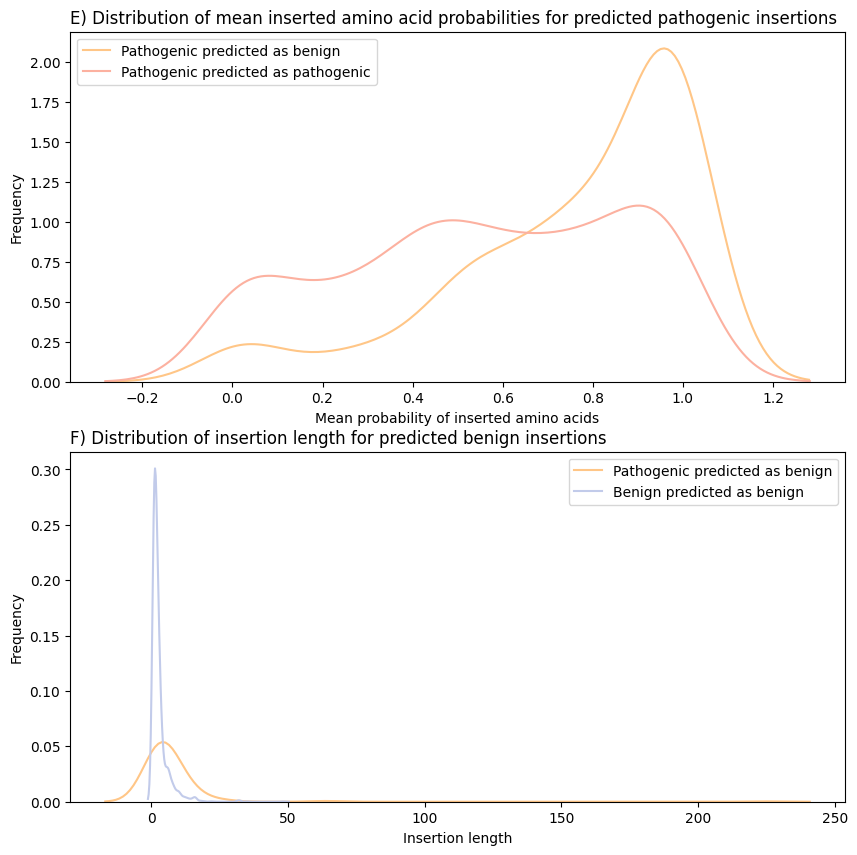

In [28]:
scoresESM2_650M_ins['mean_inserted'] = (scoresESM2_650M_ins['Brandes_mut'] - scoresESM2_650M_ins['IndeLLM_mut']) / scoresESM2_650M_ins['indel_length']

scoresESM2_650M_ins['pred_ESM2650M_IndeLLM_ins_bin'] = pred_ESM2650M_IndeLLM_ins_bin
scoresESM2_650M_ins['calling'] = scoresESM2_650M_ins.apply(lambda row: 1 if row['pred_ESM2650M_IndeLLM_ins_bin'] == row['label'] else 0, axis=1)

scoresESM2_650M_ins_pathogenic = scoresESM2_650M_ins[scoresESM2_650M_ins['label'] == 1]
scoresESM2_650M_ins_benign = scoresESM2_650M_ins[scoresESM2_650M_ins['label'] == 0]

scoresESM2_650M_ins_pathogenic_correct = scoresESM2_650M_ins_pathogenic[scoresESM2_650M_ins_pathogenic['calling'] == 1]
scoresESM2_650M_ins_benign_correct = scoresESM2_650M_ins_benign[scoresESM2_650M_ins_benign['calling'] == 1]
scoresESM2_650M_ins_pathogenic_fail = scoresESM2_650M_ins_pathogenic[scoresESM2_650M_ins_pathogenic['calling'] == 0]
scoresESM2_650M_ins_benign_fail = scoresESM2_650M_ins_benign[scoresESM2_650M_ins_benign['calling'] == 0]

# Figure S1E-S1F
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
sns.kdeplot(scoresESM2_650M_ins_pathogenic_fail['mean_inserted'], color='#FFC687', ax = axes[0], label = 'Pathogenic predicted as benign')
sns.kdeplot(scoresESM2_650M_ins_pathogenic_correct['mean_inserted'], color = '#FCB1A0', ax = axes[0], label = 'Pathogenic predicted as pathogenic')
axes[0].set_title('E) Distribution of mean inserted amino acid probabilities for predicted pathogenic insertions', loc = 'left')
axes[0].set_xlabel('Mean probability of inserted amino acids')
axes[0].set_ylabel('Frequency')
axes[0].legend()
sns.kdeplot(scoresESM2_650M_ins_pathogenic_fail['indel_length'], color='#FFC687', ax= axes[1], label = 'Pathogenic predicted as benign')
sns.kdeplot(scoresESM2_650M_ins_benign_correct['indel_length'], color = '#C2CBEA', ax= axes[1], label = 'Benign predicted as benign')
axes[1].set_title('F) Distribution of insertion length for predicted benign insertions', loc = 'left')
axes[1].set_xlabel('Insertion length')
axes[1].set_ylabel('Frequency')
axes[1].legend()

# Section 4.2 - Comparing Indel predictors performance to the IndeLLM scoring approach 
In order to compare IndeLLM to other indel pathogenicity prediction tools we used the Cannon et al. published dataset. 

First, we used the Cannon et al. subset (3478) indels identify which of the nine methods that preformes best, compared to IndeLLM and Brandes scores.
Second, we split the Cannon et al. subset by indel origin (DDD and ClinVar, 254 and 2577 indels respectively) to evalute potential overfitting.  
Third, we evaluate four methods (IndeLLM, Brandes, Provean and MutPred) for all the indel from the extended dataset (7563 indels), the training (6007 indels), validation (828 indels) and test (728 indels) datasets. For the latter analysis we use evalute the preformace on different indel types, sizes and functional associations.  

### Performace analysis of nine pathogencity prediction tools reported by Cannon et al
We evaluate the performace by calculation of false and true positives, AUC, F1-score and MCC.

In [29]:
pred_CADD = Cannonetal['CADD_Cannonetal'].values
pred_CAPICE = Cannonetal['CAPICE_Cannonetal'].values
pred_FATHMM = Cannonetal['FATHMM_Cannonetal'].values
pred_MutPred = Cannonetal['MutPred_Cannonetal'].values
Cannonetal['MutationTaster2021_bin'] = [0 if x == 'Benign' else 1 for x in Cannonetal['MutationTaster2021_Cannonetal']] # Making numerical values
pred_MutT = Cannonetal['MutationTaster2021_bin'].values
pred_PROVEAN = Cannonetal['Provean_Cannonetal'].values
Cannonetal['SIFT_bin'] = [ 0 if x == 'neutral' else 1 for x in Cannonetal['SIFT_Cannonetal']] # Making numerical values
pred_SIFT = Cannonetal['SIFT_bin'].values
pred_VEST = Cannonetal['VEST_Cannonetal'].values
pred_VVP = Cannonetal['VVP_Cannonetal'].values

#Import IndeLLM and Brandes scores into Cannonetal dataset by id
IndeLLM_Brandes_scores = Cannonetal.merge(scoresESM2_650M[['id', 'dif_IndeLLM', 'dif_Brandes']], on='id', how='left')
Cannonetal['IndeLLM'] = IndeLLM_Brandes_scores['dif_IndeLLM']
Cannonetal['Brandes'] = IndeLLM_Brandes_scores['dif_Brandes']

pred_IndeLLM_Cannonetal = Cannonetal['IndeLLM'].values
pred_Brandes_Cannonetal = Cannonetal['Brandes'].values

truelabels_Cannonetal = Cannonetal['label'].values 
truelabels_Cannonetal = 1 - truelabels_Cannonetal

fpr_CADD, tpr_CADD, thersholds_CADD = metrics.roc_curve(truelabels_Cannonetal, pred_CADD, pos_label=0)
fpr_CAPICE, tpr_CAPICE, thersholds_CAPICE = metrics.roc_curve(truelabels_Cannonetal, pred_CAPICE, pos_label=0)
fpr_FATHMM, tpr_FATHMM, thersholds_FATHMM = metrics.roc_curve(truelabels_Cannonetal, pred_FATHMM, pos_label=0)
fpr_MutPred, tpr_MutPred, thersholds_MutPred = metrics.roc_curve(truelabels_Cannonetal, pred_MutPred, pos_label=0)
fpr_MutT, tpr_MutT, thersholds_MutT = metrics.roc_curve(truelabels_Cannonetal, pred_MutT, pos_label=0)
fpr_PROVEAN, tpr_PROVEAN, thersholds_PROVEAN = metrics.roc_curve(truelabels_Cannonetal, pred_PROVEAN, pos_label=1)
fpr_SIFT, tpr_SIFT, thersholds_SIFT = metrics.roc_curve(truelabels_Cannonetal, pred_SIFT, pos_label=0)
fpr_VEST, tpr_VEST, thersholds_VEST = metrics.roc_curve(truelabels_Cannonetal, pred_VEST, pos_label=0)
fpr_VVP, tpr_VVP, thersholds_VVP = metrics.roc_curve(truelabels_Cannonetal, pred_VVP, pos_label=0)
fpr_IndeLLM_Cannon, tpr_IndeLLM_Cannon, thersholds_IndeLLM_Cannon = metrics.roc_curve(truelabels_Cannonetal, pred_IndeLLM_Cannonetal, pos_label=1)
fpr_Brandes_Cannon, tpr_Brandes_Cannon, thersholds_Brandes_Cannon = metrics.roc_curve(truelabels_Cannonetal, pred_Brandes_Cannonetal, pos_label=1)

roc_auc_CADD = round(metrics.auc(fpr_CADD, tpr_CADD), 2)
roc_auc_CAPICE = round(metrics.auc(fpr_CAPICE, tpr_CAPICE), 2)
roc_auc_FATHMM = round(metrics.auc(fpr_FATHMM, tpr_FATHMM), 2)
roc_auc_MutPred = round(metrics.auc(fpr_MutPred, tpr_MutPred), 2)
roc_auc_MutT = round(metrics.auc(fpr_MutT, tpr_MutT), 2)
roc_auc_PROVEAN = round(metrics.auc(fpr_PROVEAN, tpr_PROVEAN), 2)
roc_auc_SIFT = round(metrics.auc(fpr_SIFT, tpr_SIFT), 2)
roc_auc_VEST = round(metrics.auc(fpr_VEST, tpr_VEST), 2)
roc_auc_VVP = round(metrics.auc(fpr_VVP, tpr_VVP), 2)
roc_auc_IndeLLM_Cannon = round(metrics.auc(fpr_IndeLLM_Cannon, tpr_IndeLLM_Cannon), 2)
roc_auc_Brandes_Cannon = round(metrics.auc(fpr_Brandes_Cannon, tpr_Brandes_Cannon), 2)

tresh_CADD = thersholds_CADD[np.argmax(tpr_CADD - fpr_CADD)]
tresh_CAPICE = thersholds_CAPICE[np.argmax(tpr_CAPICE - fpr_CAPICE)]
tresh_FATHMM = thersholds_FATHMM[np.argmax(tpr_FATHMM - fpr_FATHMM)]
tresh_MutPred = thersholds_MutPred[np.argmax(tpr_MutPred - fpr_MutPred)]
tresh_MutT = thersholds_MutT[np.argmax(tpr_MutT - fpr_MutT)]
tresh_PROVEAN = thersholds_PROVEAN[np.argmax(tpr_PROVEAN - fpr_PROVEAN)]
tresh_SIFT = thersholds_SIFT[np.argmax(tpr_SIFT - fpr_SIFT)]
tresh_VEST = thersholds_VEST[np.argmax(tpr_VEST - fpr_VEST)]
tresh_VVP = thersholds_VVP[np.argmax(tpr_VVP - fpr_VVP)]
tresh_IndeLLM_Cannon = thersholds_IndeLLM_Cannon[np.argmax(tpr_IndeLLM_Cannon - fpr_IndeLLM_Cannon)]
tresh_Brandes_Cannon = thersholds_Brandes_Cannon[np.argmax(tpr_Brandes_Cannon - fpr_Brandes_Cannon)]

pred_CADD_bin = [0 if x >= tresh_CADD else 1 for x in pred_CADD]
pred_CAPICE_bin = [0 if x >= tresh_CAPICE else 1 for x in pred_CAPICE]
pred_FATHMM_bin = [0 if x >= tresh_FATHMM else 1 for x in pred_FATHMM]
pred_MutPred_bin = [0 if x >= tresh_MutPred else 1 for x in pred_MutPred]
pred_MutT_bin = [0 if x >= tresh_MutT else 1 for x in pred_MutT]
pred_PROVEAN_bin = [1 if x >= tresh_PROVEAN else 0 for x in pred_PROVEAN]
pred_SIFT_bin = [0 if x >= tresh_SIFT else 1 for x in pred_SIFT]
pred_VEST_bin = [0 if x >= tresh_VEST else 1 for x in pred_VEST]
pred_VVP_bin = [0 if x >= tresh_VVP else 1 for x in pred_VVP]
pred_IndeLLM_Cannon_bin = [1 if x >= tresh_IndeLLM_Cannon else 0 for x in pred_IndeLLM_Cannonetal]
pred_Brandes_Cannon_bin = [1 if x >= tresh_Brandes_Cannon else 0 for x in pred_Brandes_Cannonetal]

f1_CADD = f1_score(truelabels_Cannonetal, pred_CADD_bin, average = 'binary')
f1_CAPICE = f1_score(truelabels_Cannonetal, pred_CAPICE_bin, average = 'binary')
f1_FATHMM = f1_score(truelabels_Cannonetal, pred_FATHMM_bin, average = 'binary')
f1_MutPred = f1_score(truelabels_Cannonetal, pred_MutPred_bin, average = 'binary')
f1_MutT = f1_score(truelabels_Cannonetal, pred_MutT_bin, average = 'binary')
f1_PROVEAN = f1_score(truelabels_Cannonetal, pred_PROVEAN_bin, average = 'binary')
f1_SIFT = f1_score(truelabels_Cannonetal, pred_SIFT_bin, average = 'binary')
f1_VEST = f1_score(truelabels_Cannonetal, pred_VEST_bin, average = 'binary')
f1_VVP = f1_score(truelabels_Cannonetal, pred_VVP_bin, average = 'binary')
f1_IndeLLM_Cannon = f1_score(truelabels_Cannonetal, pred_IndeLLM_Cannon_bin, average = 'binary')
f1_Brandes_Cannon = f1_score(truelabels_Cannonetal, pred_Brandes_Cannon_bin, average = 'binary')

mcc_CADD = matthews_corrcoef(truelabels_Cannonetal, pred_CADD_bin)
mcc_CAPICE = matthews_corrcoef(truelabels_Cannonetal, pred_CAPICE_bin)
mcc_FATHMM = matthews_corrcoef(truelabels_Cannonetal, pred_FATHMM_bin)
mcc_MutPred = matthews_corrcoef(truelabels_Cannonetal, pred_MutPred_bin)
mcc_MutT = matthews_corrcoef(truelabels_Cannonetal, pred_MutT_bin)
mcc_PROVEAN = matthews_corrcoef(truelabels_Cannonetal, pred_PROVEAN_bin)
mcc_SIFT = matthews_corrcoef(truelabels_Cannonetal, pred_SIFT_bin)
mcc_VEST = matthews_corrcoef(truelabels_Cannonetal, pred_VEST_bin)
mcc_VVP = matthews_corrcoef(truelabels_Cannonetal, pred_VVP_bin)
mcc_IndeLLM_Cannon = matthews_corrcoef(truelabels_Cannonetal, pred_IndeLLM_Cannon_bin)
mcc_Brandes_Cannon = matthews_corrcoef(truelabels_Cannonetal, pred_Brandes_Cannon_bin)

### Plotting Figure S2A-S2B

/var/folders/5p/q6ym8f8d30bcrz8gjd8ks42h0000gn/T/ipykernel_10716/1741713541.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(fontsize = 8, frameon=False)


Text(0.0, 1.0, 'B) MCC scores for indel predictors')

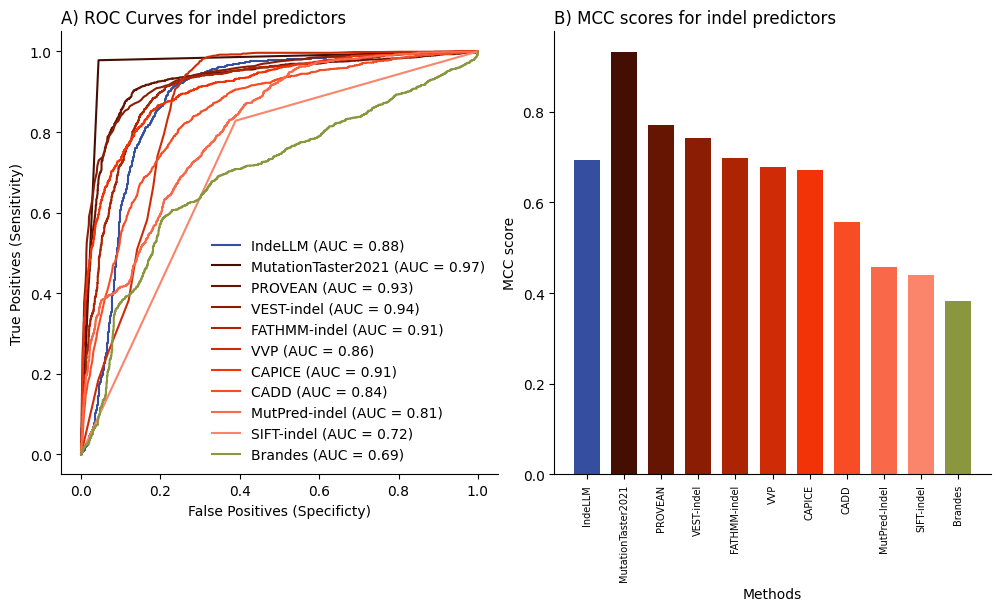

In [30]:
allscores2 = {'Method': ['IndeLLM', 'MutationTaster2021', 'PROVEAN', 'VEST-indel', 'FATHMM-indel', 'VVP', 'CAPICE', 'CADD', 'MutPred-Indel', 'SIFT-indel', 'Brandes'], 
                 'F1': [f1_IndeLLM_Cannon, f1_MutT, f1_PROVEAN, f1_VEST, f1_FATHMM, f1_VVP, f1_CAPICE, f1_CADD, f1_MutPred, f1_SIFT, f1_Brandes_Cannon], 
                 'MCC': [mcc_IndeLLM_Cannon, mcc_MutT, mcc_PROVEAN, mcc_VEST, mcc_FATHMM, mcc_VVP, mcc_CAPICE, mcc_CADD, mcc_MutPred, mcc_SIFT, mcc_Brandes_Cannon], 
                 'AUC': [roc_auc_IndeLLM_Cannon, roc_auc_MutT, roc_auc_PROVEAN, roc_auc_VEST, roc_auc_FATHMM, roc_auc_VVP, roc_auc_CAPICE, roc_auc_CADD, roc_auc_MutPred, roc_auc_SIFT, roc_auc_Brandes_Cannon]}
allscores2 = pd.DataFrame(allscores2)

colors = {
    'IndeLLM': '#364e9f',
    'MutationTaster2021': '#450e02',
    'PROVEAN': '#671503',
    'VEST-indel': '#8a1d04',
    'FATHMM-indel': '#ad2405',
    'VVP': '#cf2b06',
    'CAPICE': '#f23207',
    'CADD': '#f84c25',
    'MutPred-Indel': '#f96848',
    'SIFT-indel': '#fa856a',
    'Brandes': '#8a973e'

}

n_methods = len(allscores2['Method'])
bar_width = 0.7
r1 = np.arange(n_methods)
r2 = [x + bar_width for x in r1]

f, axes = plt.subplots(1,2)
f.set_figheight(5)
f.set_figwidth(10)
f.tight_layout(pad=1)

axes[0].plot(fpr_IndeLLM_Cannon, tpr_IndeLLM_Cannon, label = "IndeLLM (AUC = "+str(roc_auc_IndeLLM_Cannon)+")", color = "#364e9f")
axes[0].plot(fpr_MutT, tpr_MutT, label = "MutationTaster2021 (AUC = "+str(roc_auc_MutT)+")", color = "#450e02")
axes[0].plot(fpr_PROVEAN, tpr_PROVEAN, label = "PROVEAN (AUC = "+str(roc_auc_PROVEAN)+")", color = "#671503")
axes[0].plot(fpr_VEST, tpr_VEST, label = "VEST-indel (AUC = "+str(roc_auc_VEST)+")", color = "#8a1d04")
axes[0].plot(fpr_FATHMM, tpr_FATHMM, label = "FATHMM-indel (AUC = "+str(roc_auc_FATHMM)+")", color = "#ad2405")
axes[0].plot(fpr_VVP, tpr_VVP, label = "VVP (AUC = "+str(roc_auc_VVP)+")", color = "#cf2b06")
axes[0].plot(fpr_CAPICE, tpr_CAPICE, label = "CAPICE (AUC = "+str(roc_auc_CAPICE)+")", color = "#f23207")
axes[0].plot(fpr_CADD, tpr_CADD, label = "CADD (AUC = "+str(roc_auc_CADD)+")", color = "#f84c25")
axes[0].plot(fpr_MutPred, tpr_MutPred, label = "MutPred-indel (AUC = "+str(roc_auc_MutPred)+")", color = "#f96848")
axes[0].plot(fpr_SIFT, tpr_SIFT, label = "SIFT-indel (AUC = "+str(roc_auc_SIFT)+")", color = "#fa856a")
axes[0].plot(fpr_Brandes_Cannon, tpr_Brandes_Cannon, label = "Brandes (AUC = "+str(roc_auc_Brandes_Cannon)+")", color = "#8a973e")
axes[0].set_xlabel('False Positives (Specificty)')
axes[0].set_ylabel('True Positives (Sensitivity)')
axes[0].set_title("A) ROC Curves for indel predictors", loc = 'left')
axes[0].legend(loc = 'best', frameon=False)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[1].bar(r1, allscores2['MCC'], color=[colors[score] for score in allscores2['Method']], width=bar_width)
axes[1].set_ylabel('MCC score')
axes[1].set_xlabel('Methods')
axes[1].set_xticks(r1, allscores2['Method'], fontsize = 7, rotation = 90, ha = 'center')
axes[1].legend(fontsize = 8, frameon=False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_title('B) MCC scores for indel predictors', loc = 'left')

### Performace analysis of potential overfitting (DDD vs. ClinVar) and plotting of Figure S3A-S3L
We evaluate the performace by calculation of false and true positives, AUC, F1-score and MCC.

/var/folders/5p/q6ym8f8d30bcrz8gjd8ks42h0000gn/T/ipykernel_10716/3154783023.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cannonetal_DDD['MutationTaster2021_bin'] = [0 if x == 'Benign' else 1 for x in Cannonetal_DDD['MutationTaster2021_Cannonetal']] # Making numerical values
/var/folders/5p/q6ym8f8d30bcrz8gjd8ks42h0000gn/T/ipykernel_10716/3154783023.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cannonetal_DDD['SIFT_bin'] = [ 0 if x == 'neutral' else 1 for x in Cannonetal_DDD['SIFT_Cannonetal']

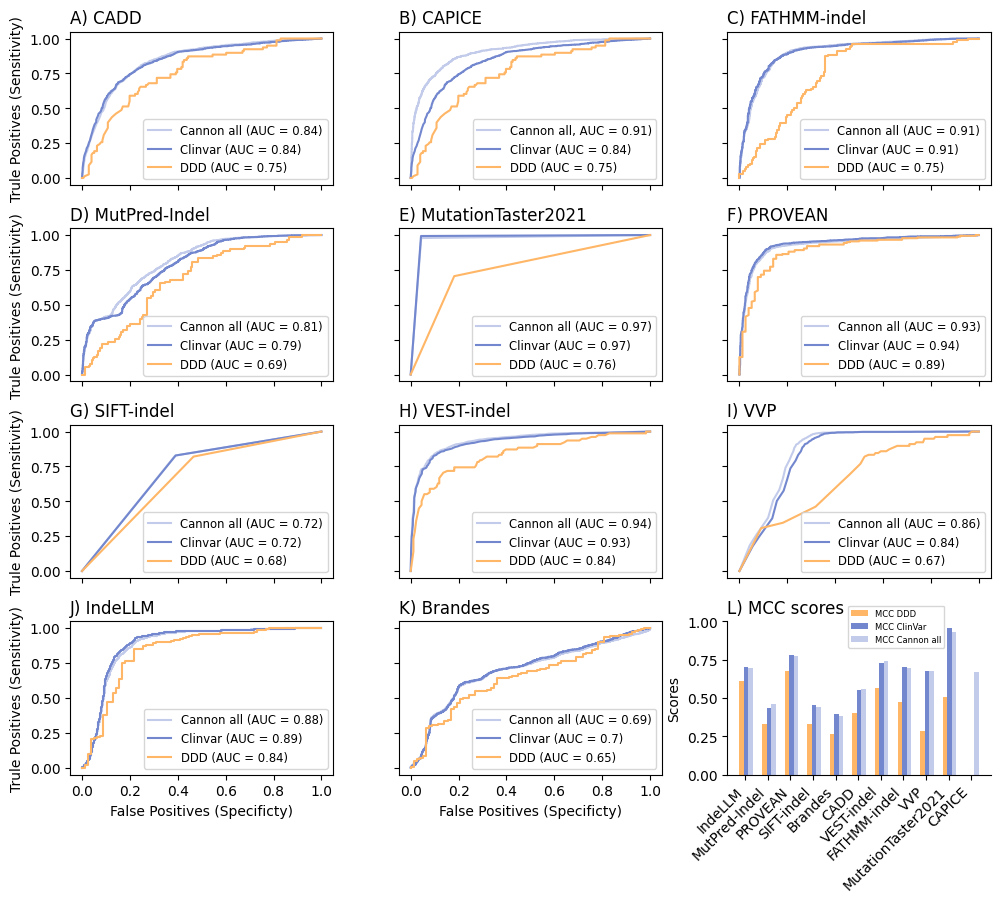

In [31]:
#Splitting Cannon et al dataset into DDD and ClinVar
Cannonetal_DDD = Cannonetal[Cannonetal['subset'] == 'Cannon et al_DDD']
Cannonetal_ClinVar = Cannonetal[Cannonetal['subset'] == 'Cannon et al_ClinVar']

#DDD split calculations
pred_CADD_DDD = Cannonetal_DDD['CADD_Cannonetal'].values
pred_CAPICE_DDD = Cannonetal_DDD['CAPICE_Cannonetal'].values
pred_FATHMM_DDD = Cannonetal_DDD['FATHMM_Cannonetal'].values
pred_MutPred_DDD = Cannonetal_DDD['MutPred_Cannonetal'].values
Cannonetal_DDD['MutationTaster2021_bin'] = [0 if x == 'Benign' else 1 for x in Cannonetal_DDD['MutationTaster2021_Cannonetal']] # Making numerical values
pred_MutT_DDD = Cannonetal_DDD['MutationTaster2021_bin'].values
pred_PROVEAN_DDD = Cannonetal_DDD['Provean_Cannonetal'].values
Cannonetal_DDD['SIFT_bin'] = [ 0 if x == 'neutral' else 1 for x in Cannonetal_DDD['SIFT_Cannonetal']] # Making numerical values
pred_SIFT_DDD = Cannonetal_DDD['SIFT_bin'].values
pred_VEST_DDD = Cannonetal_DDD['VEST_Cannonetal'].values
pred_VVP_DDD = Cannonetal_DDD['VVP_Cannonetal'].values
pred_IndeLLM_Cannonetal_DDD = Cannonetal_DDD['IndeLLM'].values
pred_Brandes_Cannonetal_DDD = Cannonetal_DDD['Brandes'].values

truelabels_Cannonetal_DDD = Cannonetal_DDD['label'].values 
truelabels_Cannonetal_DDD = 1 - truelabels_Cannonetal_DDD

fpr_CADD_DDD, tpr_CADD_DDD, thersholds_CADD_DDD = metrics.roc_curve(truelabels_Cannonetal_DDD, pred_CADD_DDD, pos_label=0)
fpr_CAPICE_DDD, tpr_CAPICE_DDD, thersholds_CAPICE_DDD = metrics.roc_curve(truelabels_Cannonetal_DDD, pred_CADD_DDD, pos_label=0)
fpr_FATHMM_DDD, tpr_FATHMM_DDD, thersholds_FATHMM_DDD = metrics.roc_curve(truelabels_Cannonetal_DDD, pred_FATHMM_DDD, pos_label=0)
fpr_MutPred_DDD, tpr_MutPred_DDD, thersholds_MutPred_DDD = metrics.roc_curve(truelabels_Cannonetal_DDD, pred_MutPred_DDD, pos_label=0)
fpr_MutT_DDD, tpr_MutT_DDD, thersholds_MutT_DDD = metrics.roc_curve(truelabels_Cannonetal_DDD, pred_MutT_DDD, pos_label=0)
fpr_PROVEAN_DDD, tpr_PROVEAN_DDD, thersholds_PROVEAN_DDD = metrics.roc_curve(truelabels_Cannonetal_DDD, pred_PROVEAN_DDD, pos_label=1)
fpr_SIFT_DDD, tpr_SIFT_DDD, thersholds_SIFT_DDD = metrics.roc_curve(truelabels_Cannonetal_DDD, pred_SIFT_DDD, pos_label=0)
fpr_VEST_DDD, tpr_VEST_DDD, thersholds_VEST_DDD = metrics.roc_curve(truelabels_Cannonetal_DDD, pred_VEST_DDD, pos_label=0)
fpr_VVP_DDD, tpr_VVP_DDD, thersholds_VVP_DDD = metrics.roc_curve(truelabels_Cannonetal_DDD, pred_VVP_DDD, pos_label=0)
fpr_IndeLLM_Cannon_DDD, tpr_IndeLLM_Cannon_DDD, thersholds_IndeLLM_Cannon_DDD = metrics.roc_curve(truelabels_Cannonetal_DDD, pred_IndeLLM_Cannonetal_DDD, pos_label=1)
fpr_Brandes_Cannon_DDD, tpr_Brandes_Cannon_DDD, thersholds_Brandes_Cannon_DDD = metrics.roc_curve(truelabels_Cannonetal_DDD, pred_Brandes_Cannonetal_DDD, pos_label=1)

roc_auc_CADD_DDD = round(metrics.auc(fpr_CADD_DDD, tpr_CADD_DDD), 2)
roc_auc_CAPICE_DDD = round(metrics.auc(fpr_CAPICE_DDD, tpr_CAPICE_DDD), 2)
roc_auc_FATHMM_DDD = round(metrics.auc(fpr_FATHMM_DDD, tpr_FATHMM_DDD), 2)
roc_auc_MutPred_DDD = round(metrics.auc(fpr_MutPred_DDD, tpr_MutPred_DDD), 2)
roc_auc_MutT_DDD = round(metrics.auc(fpr_MutT_DDD, tpr_MutT_DDD), 2)
roc_auc_PROVEAN_DDD = round(metrics.auc(fpr_PROVEAN_DDD, tpr_PROVEAN_DDD), 2)
roc_auc_SIFT_DDD = round(metrics.auc(fpr_SIFT_DDD, tpr_SIFT_DDD), 2)
roc_auc_VEST_DDD = round(metrics.auc(fpr_VEST_DDD, tpr_VEST_DDD), 2)
roc_auc_VVP_DDD = round(metrics.auc(fpr_VVP_DDD, tpr_VVP_DDD), 2)
roc_auc_IndeLLM_Cannon_DDD = round(metrics.auc(fpr_IndeLLM_Cannon_DDD, tpr_IndeLLM_Cannon_DDD), 2)
roc_auc_Brandes_Cannon_DDD = round(metrics.auc(fpr_Brandes_Cannon_DDD, tpr_Brandes_Cannon_DDD), 2)

tresh_CADD_DDD = thersholds_CADD_DDD[np.argmax(tpr_CADD_DDD - fpr_CADD_DDD)]
tresh_CAPICE_DDD = thersholds_CAPICE_DDD[np.argmax(tpr_CAPICE_DDD - fpr_CAPICE_DDD)]
tresh_FATHMM_DDD = thersholds_FATHMM_DDD[np.argmax(tpr_FATHMM_DDD - fpr_FATHMM_DDD)]
tresh_MutPred_DDD = thersholds_MutPred_DDD[np.argmax(tpr_MutPred_DDD - fpr_MutPred_DDD)]
tresh_MutT_DDD = thersholds_MutT_DDD[np.argmax(tpr_MutT_DDD - fpr_MutT_DDD)]
tresh_PROVEAN_DDD = thersholds_PROVEAN_DDD[np.argmax(tpr_PROVEAN_DDD - fpr_PROVEAN_DDD)]
tresh_SIFT_DDD = thersholds_SIFT_DDD[np.argmax(tpr_SIFT_DDD - fpr_SIFT_DDD)]
tresh_VEST_DDD = thersholds_VEST_DDD[np.argmax(tpr_VEST_DDD - fpr_VEST_DDD)]
tresh_VVP_DDD = thersholds_VVP_DDD[np.argmax(tpr_VVP_DDD - fpr_VVP_DDD)]
tresh_IndeLLM_Cannon_DDD = thersholds_IndeLLM_Cannon_DDD[np.argmax(tpr_IndeLLM_Cannon_DDD - fpr_IndeLLM_Cannon_DDD)]
tresh_Brandes_Cannon_DDD = thersholds_Brandes_Cannon_DDD[np.argmax(tpr_Brandes_Cannon_DDD - fpr_Brandes_Cannon_DDD)]

pred_CADD_bin_DDD = [0 if x >= tresh_CADD_DDD else 1 for x in pred_CADD_DDD]
pred_CAPICE_bin_DDD = [0 if x >= tresh_CAPICE_DDD else 1 for x in pred_CAPICE_DDD]
pred_FATHMM_bin_DDD = [0 if x >= tresh_FATHMM_DDD else 1 for x in pred_FATHMM_DDD]
pred_MutPred_bin_DDD = [0 if x >= tresh_MutPred_DDD else 1 for x in pred_MutPred_DDD]
pred_MutT_bin_DDD = [0 if x >= tresh_MutT_DDD else 1 for x in pred_MutT_DDD]
pred_PROVEAN_bin_DDD = [1 if x >= tresh_PROVEAN_DDD else 0 for x in pred_PROVEAN_DDD]
pred_SIFT_bin_DDD = [0 if x >= tresh_SIFT_DDD else 1 for x in pred_SIFT_DDD]
pred_VEST_bin_DDD = [0 if x >= tresh_VEST_DDD else 1 for x in pred_VEST_DDD]
pred_VVP_bin_DDD = [0 if x >= tresh_VVP_DDD else 1 for x in pred_VVP_DDD]
pred_IndeLLM_Cannon_bin_DDD = [1 if x >= tresh_IndeLLM_Cannon_DDD else 0 for x in pred_IndeLLM_Cannonetal_DDD]
pred_Brandes_Cannon_bin_DDD = [1 if x >= tresh_Brandes_Cannon_DDD else 0 for x in pred_Brandes_Cannonetal_DDD]

f1_CADD_DDD = f1_score(truelabels_Cannonetal_DDD, pred_CADD_bin_DDD, average = 'binary')
f1_CAPICE_DDD = f1_score(truelabels_Cannonetal_DDD, pred_CAPICE_bin_DDD, average = 'binary')
f1_FATHMM_DDD = f1_score(truelabels_Cannonetal_DDD, pred_FATHMM_bin_DDD, average = 'binary')
f1_MutPred_DDD = f1_score(truelabels_Cannonetal_DDD, pred_MutPred_bin_DDD, average = 'binary')
f1_MutT_DDD = f1_score(truelabels_Cannonetal_DDD, pred_MutT_bin_DDD, average = 'binary')
f1_PROVEAN_DDD = f1_score(truelabels_Cannonetal_DDD, pred_PROVEAN_bin_DDD, average = 'binary')
f1_SIFT_DDD = f1_score(truelabels_Cannonetal_DDD, pred_SIFT_bin_DDD, average = 'binary')
f1_VEST_DDD = f1_score(truelabels_Cannonetal_DDD, pred_VEST_bin_DDD, average = 'binary')
f1_VVP_DDD = f1_score(truelabels_Cannonetal_DDD, pred_VVP_bin_DDD, average = 'binary')
f1_IndeLLM_Cannon_DDD = f1_score(truelabels_Cannonetal_DDD, pred_IndeLLM_Cannon_bin_DDD, average = 'binary')
f1_Brandes_Cannon_DDD = f1_score(truelabels_Cannonetal_DDD, pred_Brandes_Cannon_bin_DDD, average = 'binary')

mcc_CADD_DDD = matthews_corrcoef(truelabels_Cannonetal_DDD, pred_CADD_bin_DDD)
mcc_CAPICE_DDD = matthews_corrcoef(truelabels_Cannonetal_DDD, pred_CAPICE_bin_DDD)
mcc_FATHMM_DDD = matthews_corrcoef(truelabels_Cannonetal_DDD, pred_FATHMM_bin_DDD)
mcc_MutPred_DDD = matthews_corrcoef(truelabels_Cannonetal_DDD, pred_MutPred_bin_DDD)
mcc_MutT_DDD = matthews_corrcoef(truelabels_Cannonetal_DDD, pred_MutT_bin_DDD)
mcc_PROVEAN_DDD = matthews_corrcoef(truelabels_Cannonetal_DDD, pred_PROVEAN_bin_DDD)
mcc_SIFT_DDD = matthews_corrcoef(truelabels_Cannonetal_DDD, pred_SIFT_bin_DDD)
mcc_VEST_DDD = matthews_corrcoef(truelabels_Cannonetal_DDD, pred_VEST_bin_DDD)
mcc_VVP_DDD = matthews_corrcoef(truelabels_Cannonetal_DDD, pred_VVP_bin_DDD)
mcc_IndeLLM_Cannon_DDD = matthews_corrcoef(truelabels_Cannonetal_DDD, pred_IndeLLM_Cannon_bin_DDD)
mcc_Brandes_Cannon_DDD = matthews_corrcoef(truelabels_Cannonetal_DDD, pred_Brandes_Cannon_bin_DDD)

#ClinVar split calculations
pred_CADD_ClinVar = Cannonetal_ClinVar['CADD_Cannonetal'].values
pred_CAPICE_ClinVar = Cannonetal_ClinVar['CAPICE_Cannonetal'].values
pred_FATHMM_ClinVar = Cannonetal_ClinVar['FATHMM_Cannonetal'].values
pred_MutPred_ClinVar = Cannonetal_ClinVar['MutPred_Cannonetal'].values
Cannonetal_ClinVar['MutationTaster2021_bin'] = [0 if x == 'Benign' else 1 for x in Cannonetal_ClinVar['MutationTaster2021_Cannonetal']] # Making numerical values
pred_MutT_ClinVar = Cannonetal_ClinVar['MutationTaster2021_bin'].values
pred_PROVEAN_ClinVar = Cannonetal_ClinVar['Provean_Cannonetal'].values
Cannonetal_ClinVar['SIFT_bin'] = [ 0 if x == 'neutral' else 1 for x in Cannonetal_ClinVar['SIFT_Cannonetal']] # Making numerical values
pred_SIFT_ClinVar = Cannonetal_ClinVar['SIFT_bin'].values
pred_VEST_ClinVar = Cannonetal_ClinVar['VEST_Cannonetal'].values
pred_VVP_ClinVar = Cannonetal_ClinVar['VVP_Cannonetal'].values
pred_IndeLLM_Cannonetal_ClinVar = Cannonetal_ClinVar['IndeLLM'].values
pred_Brandes_Cannonetal_ClinVar = Cannonetal_ClinVar['Brandes'].values

truelabels_Cannonetal_ClinVar = Cannonetal_ClinVar['label'].values 
truelabels_Cannonetal_ClinVar = 1 - truelabels_Cannonetal_ClinVar

fpr_CADD_ClinVar, tpr_CADD_ClinVar, thersholds_CADD_ClinVar = metrics.roc_curve(truelabels_Cannonetal_ClinVar, pred_CADD_ClinVar, pos_label=0)
fpr_CAPICE_ClinVar, tpr_CAPICE_ClinVar, thersholds_CAPICE_ClinVar = metrics.roc_curve(truelabels_Cannonetal_ClinVar, pred_CADD_ClinVar, pos_label=0)
fpr_FATHMM_ClinVar, tpr_FATHMM_ClinVar, thersholds_FATHMM_ClinVar = metrics.roc_curve(truelabels_Cannonetal_ClinVar, pred_FATHMM_ClinVar, pos_label=0)
fpr_MutPred_ClinVar, tpr_MutPred_ClinVar, thersholds_MutPred_ClinVar = metrics.roc_curve(truelabels_Cannonetal_ClinVar, pred_MutPred_ClinVar, pos_label=0)
fpr_MutT_ClinVar, tpr_MutT_ClinVar, thersholds_MutT_ClinVar = metrics.roc_curve(truelabels_Cannonetal_ClinVar, pred_MutT_ClinVar, pos_label=0)
fpr_PROVEAN_ClinVar, tpr_PROVEAN_ClinVar, thersholds_PROVEAN_ClinVar = metrics.roc_curve(truelabels_Cannonetal_ClinVar, pred_PROVEAN_ClinVar, pos_label=1)
fpr_SIFT_ClinVar, tpr_SIFT_ClinVar, thersholds_SIFT_ClinVar = metrics.roc_curve(truelabels_Cannonetal_ClinVar, pred_SIFT_ClinVar, pos_label=0)
fpr_VEST_ClinVar, tpr_VEST_ClinVar, thersholds_VEST_ClinVar = metrics.roc_curve(truelabels_Cannonetal_ClinVar, pred_VEST_ClinVar, pos_label=0)
fpr_VVP_ClinVar, tpr_VVP_ClinVar, thersholds_VVP_ClinVar = metrics.roc_curve(truelabels_Cannonetal_ClinVar, pred_VVP_ClinVar, pos_label=0)
fpr_IndeLLM_Cannon_ClinVar, tpr_IndeLLM_Cannon_ClinVar, thersholds_IndeLLM_Cannon_ClinVar = metrics.roc_curve(truelabels_Cannonetal_ClinVar, pred_IndeLLM_Cannonetal_ClinVar, pos_label=1)
fpr_Brandes_Cannon_ClinVar, tpr_Brandes_Cannon_ClinVar, thersholds_Brandes_Cannon_ClinVar = metrics.roc_curve(truelabels_Cannonetal_ClinVar, pred_Brandes_Cannonetal_ClinVar, pos_label=1)

roc_auc_CADD_ClinVar = round(metrics.auc(fpr_CADD_ClinVar, tpr_CADD_ClinVar), 2)
roc_auc_CAPICE_ClinVar = round(metrics.auc(fpr_CAPICE_ClinVar, tpr_CAPICE_ClinVar), 2)
roc_auc_FATHMM_ClinVar = round(metrics.auc(fpr_FATHMM_ClinVar, tpr_FATHMM_ClinVar), 2)
roc_auc_MutPred_ClinVar = round(metrics.auc(fpr_MutPred_ClinVar, tpr_MutPred_ClinVar), 2)
roc_auc_MutT_ClinVar = round(metrics.auc(fpr_MutT_ClinVar, tpr_MutT_ClinVar), 2)
roc_auc_PROVEAN_ClinVar = round(metrics.auc(fpr_PROVEAN_ClinVar, tpr_PROVEAN_ClinVar), 2)
roc_auc_SIFT_ClinVar = round(metrics.auc(fpr_SIFT_ClinVar, tpr_SIFT_ClinVar), 2)
roc_auc_VEST_ClinVar = round(metrics.auc(fpr_VEST_ClinVar, tpr_VEST_ClinVar), 2)
roc_auc_VVP_ClinVar = round(metrics.auc(fpr_VVP_ClinVar, tpr_VVP_ClinVar), 2)
roc_auc_IndeLLM_Cannon_ClinVar = round(metrics.auc(fpr_IndeLLM_Cannon_ClinVar, tpr_IndeLLM_Cannon_ClinVar), 2)
roc_auc_Brandes_Cannon_ClinVar = round(metrics.auc(fpr_Brandes_Cannon_ClinVar, tpr_Brandes_Cannon_ClinVar), 2)

tresh_CADD_ClinVar = thersholds_CADD_ClinVar[np.argmax(tpr_CADD_ClinVar - fpr_CADD_ClinVar)]
tresh_CAPICE_ClinVar = thersholds_CAPICE_ClinVar[np.argmax(tpr_CAPICE_ClinVar - fpr_CAPICE_ClinVar)]
tresh_FATHMM_ClinVar = thersholds_FATHMM_ClinVar[np.argmax(tpr_FATHMM_ClinVar - fpr_FATHMM_ClinVar)]
tresh_MutPred_ClinVar = thersholds_MutPred_ClinVar[np.argmax(tpr_MutPred_ClinVar - fpr_MutPred_ClinVar)]
tresh_MutT_ClinVar = thersholds_MutT_ClinVar[np.argmax(tpr_MutT_ClinVar - fpr_MutT_ClinVar)]
tresh_PROVEAN_ClinVar = thersholds_PROVEAN_ClinVar[np.argmax(tpr_PROVEAN_ClinVar - fpr_PROVEAN_ClinVar)]
tresh_SIFT_ClinVar = thersholds_SIFT_ClinVar[np.argmax(tpr_SIFT_ClinVar - fpr_SIFT_ClinVar)]
tresh_VEST_ClinVar = thersholds_VEST_ClinVar[np.argmax(tpr_VEST_ClinVar - fpr_VEST_ClinVar)]
tresh_VVP_ClinVar = thersholds_VVP_ClinVar[np.argmax(tpr_VVP_ClinVar - fpr_VVP_ClinVar)]
tresh_IndeLLM_Cannon_ClinVar = thersholds_IndeLLM_Cannon_ClinVar[np.argmax(tpr_IndeLLM_Cannon_ClinVar - fpr_IndeLLM_Cannon_ClinVar)]
tresh_Brandes_Cannon_ClinVar = thersholds_Brandes_Cannon_ClinVar[np.argmax(tpr_Brandes_Cannon_ClinVar - fpr_Brandes_Cannon_ClinVar)]

pred_CADD_bin_ClinVar = [0 if x >= tresh_CADD_ClinVar else 1 for x in pred_CADD_ClinVar]
pred_CAPICE_bin_ClinVar = [0 if x >= tresh_CAPICE_ClinVar else 1 for x in pred_CAPICE_ClinVar]
pred_FATHMM_bin_ClinVar = [0 if x >= tresh_FATHMM_ClinVar else 1 for x in pred_FATHMM_ClinVar]
pred_MutPred_bin_ClinVar = [0 if x >= tresh_MutPred_ClinVar else 1 for x in pred_MutPred_ClinVar]
pred_MutT_bin_ClinVar = [0 if x >= tresh_MutT_ClinVar else 1 for x in pred_MutT_ClinVar]
pred_PROVEAN_bin_ClinVar = [1 if x >= tresh_PROVEAN_ClinVar else 0 for x in pred_PROVEAN_ClinVar]
pred_SIFT_bin_ClinVar = [0 if x >= tresh_SIFT_ClinVar else 1 for x in pred_SIFT_ClinVar]
pred_VEST_bin_ClinVar = [0 if x >= tresh_VEST_ClinVar else 1 for x in pred_VEST_ClinVar]
pred_VVP_bin_ClinVar = [0 if x >= tresh_VVP_ClinVar else 1 for x in pred_VVP_ClinVar]
pred_IndeLLM_Cannon_bin_ClinVar = [1 if x >= tresh_IndeLLM_Cannon_ClinVar else 0 for x in pred_IndeLLM_Cannonetal_ClinVar]
pred_Brandes_Cannon_bin_ClinVar = [1 if x >= tresh_Brandes_Cannon_ClinVar else 0 for x in pred_Brandes_Cannonetal_ClinVar]

f1_CADD_ClinVar = f1_score(truelabels_Cannonetal_ClinVar, pred_CADD_bin_ClinVar, average = 'binary')
f1_CAPICE_ClinVar = f1_score(truelabels_Cannonetal_ClinVar, pred_CAPICE_bin_ClinVar, average = 'binary')
f1_FATHMM_ClinVar = f1_score(truelabels_Cannonetal_ClinVar, pred_FATHMM_bin_ClinVar, average = 'binary')
f1_MutPred_ClinVar = f1_score(truelabels_Cannonetal_ClinVar, pred_MutPred_bin_ClinVar, average = 'binary')
f1_MutT_ClinVar = f1_score(truelabels_Cannonetal_ClinVar, pred_MutT_bin_ClinVar, average = 'binary')
f1_PROVEAN_ClinVar = f1_score(truelabels_Cannonetal_ClinVar, pred_PROVEAN_bin_ClinVar, average = 'binary')
f1_SIFT_ClinVar = f1_score(truelabels_Cannonetal_ClinVar, pred_SIFT_bin_ClinVar, average = 'binary')
f1_VEST_ClinVar = f1_score(truelabels_Cannonetal_ClinVar, pred_VEST_bin_ClinVar, average = 'binary')
f1_VVP_ClinVar = f1_score(truelabels_Cannonetal_ClinVar, pred_VVP_bin_ClinVar, average = 'binary')
f1_IndeLLM_Cannon_ClinVar = f1_score(truelabels_Cannonetal_ClinVar, pred_IndeLLM_Cannon_bin_ClinVar, average = 'binary')
f1_Brandes_Cannon_ClinVar = f1_score(truelabels_Cannonetal_ClinVar, pred_Brandes_Cannon_bin_ClinVar, average = 'binary')

mcc_CADD_ClinVar = matthews_corrcoef(truelabels_Cannonetal_ClinVar, pred_CADD_bin_ClinVar)
mcc_CAPICE_ClinVar = matthews_corrcoef(truelabels_Cannonetal_ClinVar, pred_CAPICE_bin_ClinVar)
mcc_FATHMM_ClinVar = matthews_corrcoef(truelabels_Cannonetal_ClinVar, pred_FATHMM_bin_ClinVar)
mcc_MutPred_ClinVar = matthews_corrcoef(truelabels_Cannonetal_ClinVar, pred_MutPred_bin_ClinVar)
mcc_MutT_ClinVar = matthews_corrcoef(truelabels_Cannonetal_ClinVar, pred_MutT_bin_ClinVar)
mcc_PROVEAN_ClinVar = matthews_corrcoef(truelabels_Cannonetal_ClinVar, pred_PROVEAN_bin_ClinVar)
mcc_SIFT_ClinVar = matthews_corrcoef(truelabels_Cannonetal_ClinVar, pred_SIFT_bin_ClinVar)
mcc_VEST_ClinVar = matthews_corrcoef(truelabels_Cannonetal_ClinVar, pred_VEST_bin_ClinVar)
mcc_VVP_ClinVar = matthews_corrcoef(truelabels_Cannonetal_ClinVar, pred_VVP_bin_ClinVar)
mcc_IndeLLM_Cannon_ClinVar = matthews_corrcoef(truelabels_Cannonetal_ClinVar, pred_IndeLLM_Cannon_bin_ClinVar)
mcc_Brandes_Cannon_ClinVar = matthews_corrcoef(truelabels_Cannonetal_ClinVar, pred_Brandes_Cannon_bin_ClinVar)

topscores_overfitting = {'Method': ['CADD', 'CAPICE', 'FATHMM-indel', 'MutPred-Indel', 'MutationTaster2021', 'PROVEAN', 'SIFT-indel', 'VEST-indel', 'VVP', 'IndeLLM', 'Brandes'], 
                 'F1': [f1_CADD, f1_CAPICE, f1_FATHMM, f1_MutPred, f1_MutT, f1_PROVEAN, f1_SIFT, f1_VEST, f1_VVP, f1_IndeLLM_Cannon, f1_Brandes_Cannon], 
                 'MCC': [mcc_CADD,  mcc_CAPICE, mcc_FATHMM, mcc_MutPred, mcc_MutT, mcc_PROVEAN, mcc_SIFT, mcc_VEST, mcc_VVP, mcc_IndeLLM_Cannon, mcc_Brandes_Cannon], 
                 'F1 ClinVar': [f1_CADD_ClinVar, f1_CAPICE_ClinVar, f1_FATHMM_ClinVar, f1_MutPred_ClinVar, f1_MutT_ClinVar, f1_PROVEAN_ClinVar, f1_SIFT_ClinVar, 
                                f1_VEST_ClinVar, f1_VVP_ClinVar, f1_IndeLLM_Cannon_ClinVar, f1_Brandes_Cannon_ClinVar], 
                 'MCC ClinVar': [mcc_CADD_ClinVar, mcc_CAPICE_ClinVar, mcc_FATHMM_ClinVar, mcc_MutPred_ClinVar, mcc_MutT_ClinVar, mcc_PROVEAN_ClinVar, 
                                 mcc_SIFT_ClinVar, mcc_VEST_ClinVar, mcc_VVP_ClinVar, mcc_IndeLLM_Cannon_ClinVar, mcc_Brandes_Cannon_ClinVar],
                 'F1 DDD': [f1_CADD_DDD, f1_CAPICE_DDD, f1_FATHMM_DDD, f1_MutPred_DDD, f1_MutT_DDD, f1_PROVEAN_DDD, f1_SIFT_DDD, f1_VEST_DDD, f1_VVP_DDD, 
                            f1_IndeLLM_Cannon_DDD, f1_Brandes_Cannon_DDD], 
                 'MCC DDD': [mcc_CADD_DDD, mcc_CAPICE_DDD, mcc_FATHMM_DDD, mcc_MutPred_DDD, mcc_MutT_DDD, mcc_PROVEAN_DDD, mcc_SIFT_DDD, mcc_VEST_DDD, 
                             mcc_VVP_DDD, mcc_IndeLLM_Cannon_DDD, mcc_Brandes_Cannon_DDD], 
                 'F1 dif': [abs(f1_CADD_DDD - f1_CADD_ClinVar), abs(f1_CAPICE_DDD - f1_CAPICE), abs(f1_FATHMM_DDD - f1_FATHMM_ClinVar), 
                            abs(f1_MutPred_DDD - f1_MutPred_ClinVar), abs(f1_MutT_DDD - f1_MutT_ClinVar), abs(f1_PROVEAN_DDD - f1_PROVEAN_ClinVar), 
                            abs(f1_SIFT_DDD - f1_SIFT_ClinVar), abs(f1_VEST_DDD - f1_VEST_ClinVar), abs(f1_VVP_DDD - f1_VVP_ClinVar), 
                            abs(f1_IndeLLM_Cannon_DDD - f1_IndeLLM_Cannon_ClinVar), abs(f1_Brandes_Cannon_DDD - f1_Brandes_Cannon_ClinVar)],
                'MCC dif': [abs(mcc_CADD_DDD - mcc_CADD_ClinVar), abs(mcc_CAPICE_DDD - mcc_CAPICE), abs(mcc_FATHMM_DDD - mcc_FATHMM_ClinVar),
                            abs(mcc_MutPred_DDD - mcc_MutPred_ClinVar), abs(mcc_MutT_DDD - mcc_MutT_ClinVar), abs(mcc_PROVEAN_DDD - mcc_PROVEAN_ClinVar),
                            abs(mcc_SIFT_DDD - mcc_SIFT_ClinVar), abs(mcc_VEST_DDD - mcc_VEST_ClinVar), abs(mcc_VVP_DDD - mcc_VVP_ClinVar),
                            abs(mcc_IndeLLM_Cannon_DDD - mcc_IndeLLM_Cannon_ClinVar), abs(mcc_Brandes_Cannon_DDD - mcc_Brandes_Cannon_ClinVar)]}
topscores_overfitting = pd.DataFrame(topscores_overfitting)
topscores_overfitting = topscores_overfitting.sort_values('MCC dif', ascending=True)
topscores_overfitting = topscores_overfitting.reset_index(drop=True)

n_methods = len(topscores_overfitting['Method'])
bar_width = 0.2
r1 = np.arange(n_methods)
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

f, axes = plt.subplots(4,3)
f.set_figheight(8)
f.set_figwidth(10)
f.tight_layout(pad=1)

axes[0,0].plot(fpr_CADD, tpr_CADD, label = "Cannon all (AUC = "+str(roc_auc_CADD)+")", color = "#C2CBEA")
axes[0,0].plot(fpr_CADD_ClinVar, tpr_CADD_ClinVar, label = "Clinvar (AUC = "+str(roc_auc_CADD_ClinVar)+")", color = "#7287ce")
axes[0,0].plot(fpr_CADD_DDD, tpr_CADD_DDD, label = "DDD (AUC = "+str(roc_auc_CADD_DDD)+")", color = "#ffb666")
axes[0,0].set_title('A) CADD', loc = 'left')
axes[0,0].set_ylabel('Trule Positives (Sensitivity)')
axes[0,0].set_xlabel('')
axes[0,0].set_xticklabels('')
axes[0,0].legend(fontsize='small')

axes[0,1].plot(fpr_CAPICE, tpr_CAPICE, label = "Cannon all, AUC = "+str(roc_auc_CAPICE)+")", color = "#C2CBEA")
axes[0,1].plot(fpr_CAPICE_ClinVar, tpr_CAPICE_ClinVar, label = "Clinvar (AUC = "+str(roc_auc_CAPICE_ClinVar)+")", color = "#7287ce")
axes[0,1].plot(fpr_CAPICE_DDD, tpr_CAPICE_DDD, label = "DDD (AUC = "+str(roc_auc_CAPICE_DDD)+")", color = "#ffb666")
axes[0,1].set_title('B) CAPICE', loc = 'left')
axes[0,1].set_ylabel('')
axes[0,1].set_xlabel('')
axes[0,1].set_yticklabels('')
axes[0,1].set_xticklabels('')
axes[0,1].legend(fontsize='small')

axes[0,2].plot(fpr_FATHMM, tpr_FATHMM, label = "Cannon all (AUC = "+str(roc_auc_FATHMM)+")", color = "#C2CBEA")
axes[0,2].plot(fpr_FATHMM_ClinVar, tpr_FATHMM_ClinVar, label = "Clinvar (AUC = "+str(roc_auc_FATHMM_ClinVar)+")", color = "#7287ce")
axes[0,2].plot(fpr_FATHMM_DDD, tpr_FATHMM_DDD, label = "DDD (AUC = "+str(roc_auc_FATHMM_DDD)+")", color = "#ffb666")
axes[0,2].set_title('C) FATHMM-indel', loc = 'left')
axes[0,2].set_ylabel('')
axes[0,2].set_xlabel('')
axes[0,2].set_yticklabels('')
axes[0,2].set_xticklabels('')
axes[0,2].legend(fontsize='small')

axes[1,0].plot(fpr_MutPred, tpr_MutPred, label = "Cannon all (AUC = "+str(roc_auc_MutPred)+")", color = "#C2CBEA")
axes[1,0].plot(fpr_MutPred_ClinVar, tpr_MutPred_ClinVar, label = "Clinvar (AUC = "+str(roc_auc_MutPred_ClinVar)+")", color = "#7287ce")
axes[1,0].plot(fpr_MutPred_DDD, tpr_MutPred_DDD, label = "DDD (AUC = "+str(roc_auc_MutPred_DDD)+")", color = "#ffb666")
axes[1,0].set_title('D) MutPred-Indel', loc = 'left')
axes[1,0].set_ylabel('Trule Positives (Sensitivity)')
axes[1,0].set_xlabel('')
axes[1,0].set_xticklabels('')
axes[1,0].legend(fontsize='small')

axes[1,1].plot(fpr_MutT, tpr_MutT, label = "Cannon all (AUC = "+str(roc_auc_MutT)+")", color = "#C2CBEA")
axes[1,1].plot(fpr_MutT_ClinVar, tpr_MutT_ClinVar, label = "Clinvar (AUC = "+str(roc_auc_MutT_ClinVar)+")", color = "#7287ce")
axes[1,1].plot(fpr_MutT_DDD, tpr_MutT_DDD, label = "DDD (AUC = "+str(roc_auc_MutT_DDD)+")", color = "#ffb666")
axes[1,1].set_title('E) MutationTaster2021', loc = 'left')
axes[1,1].set_ylabel('')
axes[1,1].set_xlabel('')
axes[1,1].set_yticklabels('')
axes[1,1].set_xticklabels('')
axes[1,1].legend(fontsize='small')

axes[1,2].plot(fpr_PROVEAN, tpr_PROVEAN, label = "Cannon all (AUC = "+str(roc_auc_PROVEAN)+")", color = "#C2CBEA")
axes[1,2].plot(fpr_PROVEAN_ClinVar, tpr_PROVEAN_ClinVar, label = "Clinvar (AUC = "+str(roc_auc_PROVEAN_ClinVar)+")", color = "#7287ce")
axes[1,2].plot(fpr_PROVEAN_DDD, tpr_PROVEAN_DDD, label = "DDD (AUC = "+str(roc_auc_PROVEAN_DDD)+")", color = "#ffb666")
axes[1,2].set_title('F) PROVEAN', loc = 'left')
axes[1,2].set_ylabel('')
axes[1,2].set_xlabel('')
axes[1,2].set_yticklabels('')
axes[1,2].set_xticklabels('')
axes[1,2].legend(fontsize='small')

axes[2,0].plot(fpr_SIFT, tpr_SIFT, label = "Cannon all (AUC = "+str(roc_auc_SIFT)+")", color = "#C2CBEA")
axes[2,0].plot(fpr_SIFT_ClinVar, tpr_SIFT_ClinVar, label = "Clinvar (AUC = "+str(roc_auc_SIFT_ClinVar)+")", color = "#7287ce")
axes[2,0].plot(fpr_SIFT_DDD, tpr_SIFT_DDD, label = "DDD (AUC = "+str(roc_auc_SIFT_DDD)+")", color = "#ffb666")
axes[2,0].set_title('G) SIFT-indel', loc = 'left')
axes[2,0].set_ylabel('Trule Positives (Sensitivity)')
axes[2,0].set_xlabel('')
axes[2,0].set_xticklabels('')
axes[2,0].legend(fontsize='small')

axes[2,1].plot(fpr_VEST, tpr_VEST, label = "Cannon all (AUC = "+str(roc_auc_VEST)+")", color = "#C2CBEA")
axes[2,1].plot(fpr_VEST_ClinVar, tpr_VEST_ClinVar, label = "Clinvar (AUC = "+str(roc_auc_VEST_ClinVar)+")", color = "#7287ce")
axes[2,1].plot(fpr_VEST_DDD, tpr_VEST_DDD, label = "DDD (AUC = "+str(roc_auc_VEST_DDD)+")", color = "#ffb666")
axes[2,1].set_title('H) VEST-indel', loc = 'left')
axes[2,1].set_ylabel('')
axes[2,1].set_xlabel('')
axes[2,1].set_yticklabels('')
axes[2,1].set_xticklabels('')
axes[2,1].legend(fontsize='small')

axes[2,2].plot(fpr_VVP, tpr_VVP, label = "Cannon all (AUC = "+str(roc_auc_VVP)+")", color = "#C2CBEA")
axes[2,2].plot(fpr_VVP_ClinVar, tpr_VVP_ClinVar, label = "Clinvar (AUC = "+str(roc_auc_VVP_ClinVar)+")", color = "#7287ce")
axes[2,2].plot(fpr_VVP_DDD, tpr_VVP_DDD, label = "DDD (AUC = "+str(roc_auc_VVP_DDD)+")", color = "#ffb666")
axes[2,2].set_title('I) VVP', loc = 'left')
axes[2,2].set_ylabel('')
axes[2,2].set_xlabel('')
axes[2,2].set_yticklabels('')
axes[2,2].set_xticklabels('')
axes[2,2].legend(fontsize='small')

axes[3,0].plot(fpr_IndeLLM_Cannon, tpr_IndeLLM_Cannon, label = "Cannon all (AUC = "+str(roc_auc_IndeLLM_Cannon)+")", color = "#C2CBEA")
axes[3,0].plot(fpr_IndeLLM_Cannon_ClinVar, tpr_IndeLLM_Cannon_ClinVar, label = "Clinvar (AUC = "+str(roc_auc_IndeLLM_Cannon_ClinVar)+")", color = "#7287ce")
axes[3,0].plot(fpr_IndeLLM_Cannon_DDD, tpr_IndeLLM_Cannon_DDD, label = "DDD (AUC = "+str(roc_auc_IndeLLM_Cannon_DDD)+")", color = "#ffb666")
axes[3,0].set_title('J) IndeLLM', loc = 'left')
axes[3,0].set_ylabel('Trule Positives (Sensitivity)')
axes[3,0].set_xlabel('False Positives (Specificty)')
axes[3,0].legend(fontsize='small')

axes[3,1].plot(fpr_Brandes_Cannon, tpr_Brandes_Cannon, label = "Cannon all (AUC = "+str(roc_auc_Brandes_Cannon)+")", color = "#C2CBEA")
axes[3,1].plot(fpr_Brandes_Cannon_ClinVar, tpr_Brandes_Cannon_ClinVar, label = "Clinvar (AUC = "+str(roc_auc_Brandes_Cannon_ClinVar)+")", color = "#7287ce")
axes[3,1].plot(fpr_Brandes_Cannon_DDD, tpr_Brandes_Cannon_DDD, label = "DDD (AUC = "+str(roc_auc_Brandes_Cannon_DDD)+")", color = "#ffb666")
axes[3,1].set_title('K) Brandes', loc = 'left')
axes[3,1].set_ylabel('')
axes[3,1].set_xlabel('False Positives (Specificty)')
axes[3,1].set_yticklabels('')
axes[3,1].legend(fontsize='small')

axes[3,2].bar(r1, topscores_overfitting['MCC DDD'], width=bar_width, label='MCC DDD', color = '#ffb666')
axes[3,2].bar(r2, topscores_overfitting['MCC ClinVar'], width=bar_width, label='MCC ClinVar', color = '#7287ce')
axes[3,2].bar(r3, topscores_overfitting['MCC'], width=bar_width, label='MCC Cannon all', color = '#C2CBEA')
axes[3,2].set_title('L) MCC scores', loc = 'left')
axes[3,2].set_xlabel('')
axes[3,2].set_ylabel('Scores')
axes[3,2].set_xticks([r + (0.8*bar_width) for r in range(n_methods)])
axes[3,2].set_xticklabels(topscores_overfitting['Method'], rotation = 45, ha='right')
axes[3,2].spines['top'].set_visible(False)
axes[3,2].spines['right'].set_visible(False)
axes[3,2].legend(fontsize = 6 , bbox_to_anchor=(0.84, 0.8))

### Performace analysis of IndeLLM and pathogencity prediction tools Provean and MutPred-Indel on extended dataset and splits
Based on the results above we find that Provean and MutPred-Indel is one of the best performing methods that is not overfitted. We evaluate the performace by calculation of false and true positives, AUC, F1-score and MCC.

In [32]:
#Adding ESM2_650M IndeLLM scores to test, validation and train datasets so that we can see the difference in datasets
train['dif_IndeLLM'] = train.apply(lambda row: scoresESM2_650M[scoresESM2_650M['id'] == row['id']]['dif_IndeLLM'].values[0], axis=1)
test['dif_IndeLLM'] = test.apply(lambda row: scoresESM2_650M[scoresESM2_650M['id'] == row['id']]['dif_IndeLLM'].values[0], axis=1)
val['dif_IndeLLM'] = val.apply(lambda row: scoresESM2_650M[scoresESM2_650M['id'] == row['id']]['dif_IndeLLM'].values[0], axis=1)

# IndeLLM scores on smaller datasets
pred_ESM2650M_IndeLLM_train = train['dif_IndeLLM'].values
pred_ESM2650M_IndeLLM_val = val['dif_IndeLLM'].values
pred_ESM2650M_IndeLLM_test = test['dif_IndeLLM'].values

# Other predictors on full datasets and splits
pred_Provean_alldata = alldata['Provean'].values
pred_Provean_train = train['Provean'].values
pred_Provean_val = val['Provean'].values
pred_Provean_test = test['Provean'].values
pred_MutPred_alldata = alldata['MutPred-Indel'].values
pred_MutPred_train = train['MutPred-Indel'].values
pred_MutPred_val = val['MutPred-Indel'].values
pred_MutPred_test = test['MutPred-Indel'].values

#Extracting the true labels for each dataset split
truelabels_train = train['label'].values
truelabels_val = val['label'].values
truelabels_test = test['label'].values

fpr_ESM2650M_train, tpr_ESM2650M_train, thersholds_ESM2650M_train = metrics.roc_curve(truelabels_train, pred_ESM2650M_IndeLLM_train, pos_label=0)
fpr_ESM2650M_val, tpr_ESM2650M_val, thersholds_ESM2650M_val = metrics.roc_curve(truelabels_val, pred_ESM2650M_IndeLLM_val, pos_label=0)
fpr_ESM2650M_test, tpr_ESM2650M_test, thersholds_ESM2650M_test = metrics.roc_curve(truelabels_test, pred_ESM2650M_IndeLLM_test, pos_label=0)
fpr_Provean_alldata, tpr_Provean_alldata, thersholds_Provean_alldata = metrics.roc_curve(truelabels_alldata, pred_Provean_alldata, pos_label=0)
fpr_Provean_train, tpr_Provean_train, thersholds_Provean_train = metrics.roc_curve(truelabels_train, pred_Provean_train, pos_label=0)
fpr_Provean_val, tpr_Provean_val, thersholds_Provean_val = metrics.roc_curve(truelabels_val, pred_Provean_val, pos_label=0)
fpr_Provean_test, tpr_Provean_test, thersholds_Provean_test = metrics.roc_curve(truelabels_test, pred_Provean_test, pos_label=0)
fpr_MutPred_alldata, tpr_MutPred_alldata, thersholds_MutPred_alldata = metrics.roc_curve(truelabels_alldata, pred_MutPred_alldata, pos_label=1)
fpr_MutPred_train, tpr_MutPred_train, thersholds_MutPred_train = metrics.roc_curve(truelabels_train, pred_MutPred_train, pos_label=1)
fpr_MutPred_val, tpr_MutPred_val, thersholds_MutPred_val = metrics.roc_curve(truelabels_val, pred_MutPred_val, pos_label=1)
fpr_MutPred_test, tpr_MutPred_test, thersholds_MutPred_test = metrics.roc_curve(truelabels_test, pred_MutPred_test, pos_label=1)

roc_auc_ESM2650M_train = round(metrics.auc(fpr_ESM2650M_train, tpr_ESM2650M_train), 2)
roc_auc_ESM2650M_val = round(metrics.auc(fpr_ESM2650M_val, tpr_ESM2650M_val), 2)
roc_auc_ESM2650M_test = round(metrics.auc(fpr_ESM2650M_test, tpr_ESM2650M_test), 2)
roc_auc_Provean_alldata = round(metrics.auc(fpr_Provean_alldata, tpr_Provean_alldata), 2)
roc_auc_Provean_train = round(metrics.auc(fpr_Provean_train, tpr_Provean_train), 2)
roc_auc_Provean_val = round(metrics.auc(fpr_Provean_val, tpr_Provean_val), 2)
roc_auc_Provean_test = round(metrics.auc(fpr_Provean_test, tpr_Provean_test), 2)
roc_auc_MutPred_alldata = round(metrics.auc(fpr_MutPred_alldata, tpr_MutPred_alldata), 2)
roc_auc_MutPred_train = round(metrics.auc(fpr_MutPred_train, tpr_MutPred_train), 2)
roc_auc_MutPred_val = round(metrics.auc(fpr_MutPred_val, tpr_MutPred_val), 2)
roc_auc_MutPred_test = round(metrics.auc(fpr_MutPred_test, tpr_MutPred_test), 2)

tresh_ESM2650M_train = thersholds_ESM2650M_train[np.argmax(tpr_ESM2650M_train - fpr_ESM2650M_train)]
tresh_ESM2650M_val = thersholds_ESM2650M_val[np.argmax(tpr_ESM2650M_val - fpr_ESM2650M_val)]
tresh_ESM2650M_test = thersholds_ESM2650M_test[np.argmax(tpr_ESM2650M_test - fpr_ESM2650M_test)]
tresh_Provean_alldata = thersholds_Provean_alldata[np.argmax(tpr_Provean_alldata - fpr_Provean_alldata)]
tresh_Provean_train = thersholds_Provean_train[np.argmax(tpr_Provean_train - fpr_Provean_train)]
tresh_Provean_val = thersholds_Provean_val[np.argmax(tpr_Provean_val - fpr_Provean_val)]
tresh_Provean_test = thersholds_Provean_test[np.argmax(tpr_Provean_test - fpr_Provean_test)]
tresh_MutPred_alldata = thersholds_MutPred_alldata[np.argmax(tpr_MutPred_alldata - fpr_MutPred_alldata)]
tresh_MutPred_train = thersholds_MutPred_train[np.argmax(tpr_MutPred_train - fpr_MutPred_train)]
tresh_MutPred_val = thersholds_MutPred_val[np.argmax(tpr_MutPred_val - fpr_MutPred_val)]
tresh_MutPred_test = thersholds_MutPred_test[np.argmax(tpr_MutPred_test - fpr_MutPred_test)]

pred_ESM2650M_train_bin = [0 if x >= tresh_ESM2650M_train else 1 for x in pred_ESM2650M_IndeLLM_train]
pred_ESM2650M_val_bin = [0 if x >= tresh_ESM2650M_val else 1 for x in pred_ESM2650M_IndeLLM_val]
pred_ESM2650M_test_bin = [0 if x >= tresh_ESM2650M_test else 1 for x in pred_ESM2650M_IndeLLM_test]
pred_Provean_alldata_bin = [0 if x >= tresh_Provean_alldata else 1 for x in pred_Provean_alldata]
pred_Provean_train_bin = [0 if x >= tresh_Provean_train else 1 for x in pred_Provean_train]
pred_Provean_val_bin = [0 if x >= tresh_Provean_val else 1 for x in pred_Provean_val]
pred_Provean_test_bin = [0 if x >= tresh_Provean_test else 1 for x in pred_Provean_test]
pred_MutPred_alldata_bin = [1 if x >= tresh_MutPred_alldata else 0 for x in pred_MutPred_alldata]
pred_MutPred_train_bin = [1 if x >= tresh_MutPred_train else 0 for x in pred_MutPred_train]
pred_MutPred_val_bin = [1 if x >= tresh_MutPred_val else 0 for x in pred_MutPred_val]
pred_MutPred_test_bin = [1 if x >= tresh_MutPred_test else 0 for x in pred_MutPred_test]

f1_ESM2650M_train = f1_score(truelabels_train, pred_ESM2650M_train_bin, average = 'binary', pos_label=0)
f1_ESM2650M_val = f1_score(truelabels_val, pred_ESM2650M_val_bin, average = 'binary', pos_label=0)
f1_ESM2650M_test = f1_score(truelabels_test, pred_ESM2650M_test_bin, average = 'binary', pos_label=0)
f1_Provean_alldata = f1_score(truelabels_alldata, pred_Provean_alldata_bin, average = 'binary', pos_label=0)
f1_Provean_train = f1_score(truelabels_train, pred_Provean_train_bin, average = 'binary', pos_label=0)
f1_Provean_val = f1_score(truelabels_val, pred_Provean_val_bin, average = 'binary', pos_label=0)
f1_Provean_test = f1_score(truelabels_test, pred_Provean_test_bin, average = 'binary', pos_label=0)
f1_MutPred_alldata = f1_score(truelabels_alldata, pred_MutPred_alldata_bin, average = 'binary', pos_label=0)
f1_MutPred_train = f1_score(truelabels_train, pred_MutPred_train_bin, average = 'binary', pos_label=0)
f1_MutPred_val = f1_score(truelabels_val, pred_MutPred_val_bin, average = 'binary', pos_label=0)
f1_MutPred_test = f1_score(truelabels_test, pred_MutPred_test_bin, average = 'binary', pos_label=0)

mcc_ESM2650M_train = matthews_corrcoef(truelabels_train, pred_ESM2650M_train_bin)
mcc_ESM2650M_val = matthews_corrcoef(truelabels_val, pred_ESM2650M_val_bin)
mcc_ESM2650M_test = matthews_corrcoef(truelabels_test, pred_ESM2650M_test_bin)
mcc_Provean_alldata = matthews_corrcoef(truelabels_alldata, pred_Provean_alldata_bin)
mcc_Provean_train = matthews_corrcoef(truelabels_train, pred_Provean_train_bin)
mcc_Provean_val = matthews_corrcoef(truelabels_val, pred_Provean_val_bin)
mcc_Provean_test = matthews_corrcoef(truelabels_test, pred_Provean_test_bin)
mcc_MutPred_alldata = matthews_corrcoef(truelabels_alldata, pred_MutPred_alldata_bin)
mcc_MutPred_train = matthews_corrcoef(truelabels_train, pred_MutPred_train_bin)
mcc_MutPred_val = matthews_corrcoef(truelabels_val, pred_MutPred_val_bin)
mcc_MutPred_test = matthews_corrcoef(truelabels_test, pred_MutPred_test_bin)


### Plotting of Figure 2

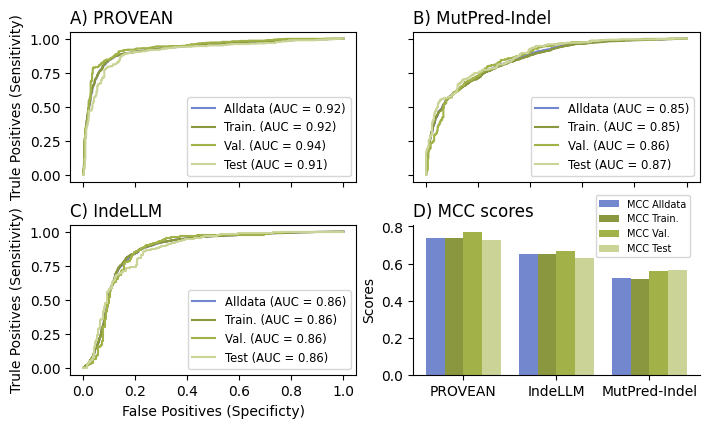

In [33]:
# Add the IndeLLM trained here!!
topscores_overfitting = {'Method': ['PROVEAN', 'MutPred-Indel', 'IndeLLM'], 
                 'F1 Alldata': [f1_Provean_alldata, f1_MutPred_alldata, f1_ESM2650M_IndeLLM], 
                 'MCC Alldata': [mcc_Provean_alldata,  mcc_MutPred_alldata, mcc_ESM2650M_IndeLLM], 
                 'F1 Train.': [f1_Provean_train,  f1_MutPred_train, f1_ESM2650M_train], 
                 'MCC Train.': [mcc_Provean_train, mcc_MutPred_train, mcc_ESM2650M_train],
                 'F1 Val.': [f1_Provean_val, f1_MutPred_val, f1_ESM2650M_val], 
                 'MCC Val.': [mcc_Provean_val,  mcc_MutPred_val, mcc_ESM2650M_val], 
                 'F1 Test': [f1_Provean_test, f1_MutPred_test, f1_ESM2650M_test],
                 'MCC Test': [mcc_Provean_test, mcc_MutPred_test, mcc_ESM2650M_test],
                 'F1 diff': [abs(f1_Provean_alldata - f1_Provean_test), abs(f1_MutPred_alldata - f1_MutPred_test), abs(f1_ESM2650M_IndeLLM - f1_ESM2650M_test)],
                 'MCC diff': [abs(mcc_Provean_alldata - mcc_Provean_test), abs(mcc_MutPred_alldata - mcc_MutPred_test), abs(mcc_ESM2650M_IndeLLM - mcc_ESM2650M_test)]}
topscores_overfitting = pd.DataFrame(topscores_overfitting)
topscores_overfitting = topscores_overfitting.sort_values('MCC diff', ascending=True)
topscores_overfitting = topscores_overfitting.reset_index(drop=True)

n_methods = len(topscores_overfitting['Method'])
bar_width = 0.2
r1 = np.arange(n_methods)
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

f, axes = plt.subplots(2,2)
f.set_figheight(4)
f.set_figwidth(7)
f.tight_layout(pad=1)

axes[0,0].plot(fpr_Provean_alldata, tpr_Provean_alldata, label = "Alldata (AUC = "+str(roc_auc_Provean_alldata)+")", color = "#7287ce")
axes[0,0].plot(fpr_Provean_train, tpr_Provean_train, label = "Train. (AUC = "+str(roc_auc_Provean_train)+")", color = "#8a973e")
axes[0,0].plot(fpr_Provean_val, tpr_Provean_val, label = "Val. (AUC = "+str(roc_auc_Provean_val)+")", color = "#A2b148")
axes[0,0].plot(fpr_Provean_test, tpr_Provean_test, label = "Test (AUC = "+str(roc_auc_Provean_test)+")", color = "#CBD496")
axes[0,0].set_title('A) PROVEAN', loc = 'left')
axes[0,0].set_ylabel('Trule Positives (Sensitivity)')
axes[0,0].set_xlabel('')
axes[0,0].set_xticklabels('')
axes[0,0].legend(fontsize='small')

axes[0,1].plot(fpr_MutPred_alldata, tpr_MutPred_alldata, label = "Alldata (AUC = "+str(roc_auc_MutPred_alldata)+")", color = "#7287ce")
axes[0,1].plot(fpr_MutPred_train, tpr_MutPred_train, label = "Train. (AUC = "+str(roc_auc_MutPred_train)+")", color = "#8a973e")
axes[0,1].plot(fpr_MutPred_val, tpr_MutPred_val, label = "Val. (AUC = "+str(roc_auc_MutPred_val)+")", color = "#A2b148")
axes[0,1].plot(fpr_MutPred_test, tpr_MutPred_test, label = "Test (AUC = "+str(roc_auc_MutPred_test)+")", color = "#CBD496")
axes[0,1].set_title('B) MutPred-Indel', loc = 'left')
axes[0,1].set_ylabel('')
axes[0,1].set_xlabel('')
axes[0,1].set_yticklabels('')
axes[0,1].set_xticklabels('')
axes[0,1].legend(fontsize='small')

axes[1,0].plot(fpr_ESM2650M_IndeLLM, tpr_ESM2650M_IndeLLM, label = "Alldata (AUC = "+str(roc_auc_ESM2650M_IndeLLM)+")", color = "#7287ce")
axes[1,0].plot(fpr_ESM2650M_train, tpr_ESM2650M_train, label = "Train. (AUC = "+str(roc_auc_ESM2650M_train)+")", color = "#8a973e")
axes[1,0].plot(fpr_ESM2650M_val, tpr_ESM2650M_val, label = "Val. (AUC = "+str(roc_auc_ESM2650M_val)+")", color = "#A2b148")
axes[1,0].plot(fpr_ESM2650M_test, tpr_ESM2650M_test, label = "Test (AUC = "+str(roc_auc_ESM2650M_test)+")", color = "#CBD496")
axes[1,0].set_title('C) IndeLLM', loc = 'left')
axes[1,0].set_ylabel('Trule Positives (Sensitivity)')
axes[1,0].set_xlabel('False Positives (Specificty)')
axes[1,0].legend(fontsize='small')

axes[1,1].bar(r1, topscores_overfitting['MCC Alldata'], width=bar_width, label='MCC Alldata', color = '#7287ce')
axes[1,1].bar(r2, topscores_overfitting['MCC Train.'], width=bar_width, label='MCC Train.', color = '#8a973e')
axes[1,1].bar(r3, topscores_overfitting['MCC Val.'], width=bar_width, label='MCC Val.', color = '#A2b148')
axes[1,1].bar(r4, topscores_overfitting['MCC Test'], width=bar_width, label='MCC Test', color = '#CBD496')
axes[1,1].set_title('D) MCC scores', loc = 'left')
axes[1,1].set_xlabel('')
axes[1,1].set_ylabel('Scores')
axes[1,1].set_xticks([r + (1.5*bar_width) for r in range(n_methods)])
axes[1,1].set_xticklabels(topscores_overfitting['Method'])
axes[1,1].spines['top'].set_visible(False)
axes[1,1].spines['right'].set_visible(False)
axes[1,1].legend(fontsize = 7 , bbox_to_anchor=(0.62, 0.75))

### Performace analysis of indel type, sizes and functional association of IndeLLM and pathogencity prediction tools Provean and MutPred-Indel on test dataset
We evaluate the performace by calculation of false and true positives and confusion matrixes. 
We show that Provean, MutPred-indel and IndeLLM has different weakness and strengths. 

### Indel type (insertions vs deletion)

/var/folders/5p/q6ym8f8d30bcrz8gjd8ks42h0000gn/T/ipykernel_10716/1352673941.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.8, 0.95])


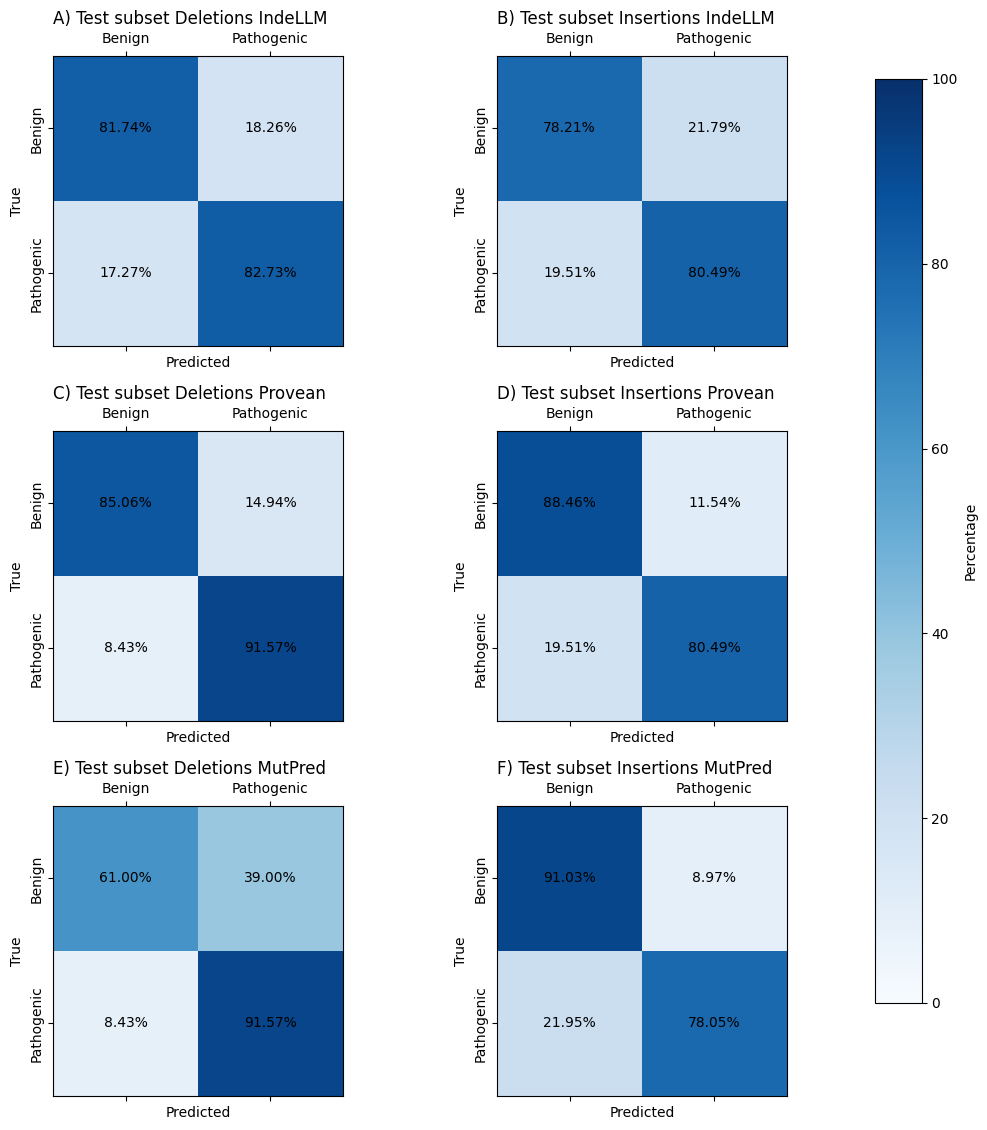

In [34]:
test_ins = test[test['indel_type'] == 'insertion']
test_del = test[test['indel_type'] == 'deletion']

pred_test_ins_IndeLLM = test_ins['dif_IndeLLM'].values
pred_test_del_IndeLLM = test_del['dif_IndeLLM'].values
pred_test_ins_Provean = test_ins['Provean'].values
pred_test_del_Provean = test_del['Provean'].values
pred_test_ins_MutPred = test_ins['MutPred-Indel'].values
pred_test_del_MutPred = test_del['MutPred-Indel'].values

truelabels_test_ins = test_ins['label'].values
truelabels_test_del = test_del['label'].values

fpr_test_ins_IndeLLM, tpr_test_ins_IndeLLM, thersholds_test_ins_IndeLLM = metrics.roc_curve(truelabels_test_ins, pred_test_ins_IndeLLM, pos_label=0)
fpr_test_del_IndeLLM, tpr_test_del_IndeLLM, thersholds_test_del_IndeLLM = metrics.roc_curve(truelabels_test_del, pred_test_del_IndeLLM, pos_label=0)
fpr_test_ins_Provean, tpr_test_ins_Provean, thersholds_test_ins_Provean = metrics.roc_curve(truelabels_test_ins, pred_test_ins_Provean, pos_label=0)
fpr_test_del_Provean, tpr_test_del_Provean, thersholds_test_del_Provean = metrics.roc_curve(truelabels_test_del, pred_test_del_Provean, pos_label=0)
fpr_test_ins_MutPred, tpr_test_ins_MutPred, thersholds_test_ins_MutPred = metrics.roc_curve(truelabels_test_ins, pred_test_ins_MutPred, pos_label=1)
fpr_test_del_MutPred, tpr_test_del_MutPred, thersholds_test_del_MutPred = metrics.roc_curve(truelabels_test_del, pred_test_del_MutPred, pos_label=1)

tresh_test_ins_IndeLLM = thersholds_test_ins_IndeLLM[np.argmax(tpr_test_ins_IndeLLM - fpr_test_ins_IndeLLM)]
tresh_test_del_IndeLLM = thersholds_test_del_IndeLLM[np.argmax(tpr_test_del_IndeLLM - fpr_test_del_IndeLLM)]
tresh_test_ins_Provean = thersholds_test_ins_Provean[np.argmax(tpr_test_ins_Provean - fpr_test_ins_Provean)]
tresh_test_del_Provean = thersholds_test_del_Provean[np.argmax(tpr_test_del_Provean - fpr_test_del_Provean)]
tresh_test_ins_MutPred = thersholds_test_ins_MutPred[np.argmax(tpr_test_ins_MutPred - fpr_test_ins_MutPred)]
tresh_test_del_MutPred = thersholds_test_del_MutPred[np.argmax(tpr_test_del_MutPred - fpr_test_del_MutPred)]

pred_test_ins_IndeLLM_bin = [0 if x >= tresh_test_ins_IndeLLM else 1 for x in pred_test_ins_IndeLLM]
pred_test_del_IndeLLM_bin = [0 if x >= tresh_test_del_IndeLLM else 1 for x in pred_test_del_IndeLLM]
pred_test_ins_Provean_bin = [0 if x >= tresh_test_ins_Provean else 1 for x in pred_test_ins_Provean]
pred_test_del_Provean_bin = [0 if x >= tresh_test_del_Provean else 1 for x in pred_test_del_Provean]
pred_test_ins_MutPred_bin = [1 if x >= tresh_test_ins_MutPred else 0 for x in pred_test_ins_MutPred]
pred_test_del_MutPred_bin = [1 if x >= tresh_test_del_MutPred else 0 for x in pred_test_del_MutPred]

confusion_test_ins_IndeLLM = confusion_matrix(truelabels_test_ins, pred_test_ins_IndeLLM_bin)
confusion_test_del_IndeLLM = confusion_matrix(truelabels_test_del, pred_test_del_IndeLLM_bin)
confusion_test_ins_Provean = confusion_matrix(truelabels_test_ins, pred_test_ins_Provean_bin)
confusion_test_del_Provean = confusion_matrix(truelabels_test_del, pred_test_del_Provean_bin)
confusion_test_ins_MutPred = confusion_matrix(truelabels_test_ins, pred_test_ins_MutPred_bin)
confusion_test_del_MutPred = confusion_matrix(truelabels_test_del, pred_test_del_MutPred_bin)

titles_test = [
    "A) Test subset Deletions IndeLLM",
    "B) Test subset Insertions IndeLLM",
    "C) Test subset Deletions Provean",
    "D) Test subset Insertions Provean", 
    "E) Test subset Deletions MutPred",
    "F) Test subset Insertions MutPred"
]
confusions_test = [
    confusion_test_del_IndeLLM,
    confusion_test_ins_IndeLLM,
    confusion_test_del_Provean,
    confusion_test_ins_Provean,
    confusion_test_del_MutPred,
    confusion_test_ins_MutPred
]

fig_test, axes_test = plt.subplots(3, 2, figsize=(12, 12))
for ax, confusion_test, title_test in zip(axes_test.ravel(), confusions_test, titles_test):
    cax_matrix_test = plot_percentage_confusion_matrix(confusion_test, title_test, labels, ax=ax)
fig_test.colorbar(cax_matrix_test, ax=axes_test.ravel().tolist(), orientation='vertical', fraction=0.05, pad=0.05, label='Percentage')
plt.tight_layout(rect=[0, 0, 0.8, 0.95])

### Indel size (small: 1-2 amino acids, long: >=3 amino acids)

Import the indel length from the score dataframe

In [35]:
test = test.merge(scoresESM2_650M[['id','indel_length']], on='id', how='left')
test['indel_length'] = test['indel_length'].abs()

/var/folders/5p/q6ym8f8d30bcrz8gjd8ks42h0000gn/T/ipykernel_10716/163122846.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.8, 0.95])


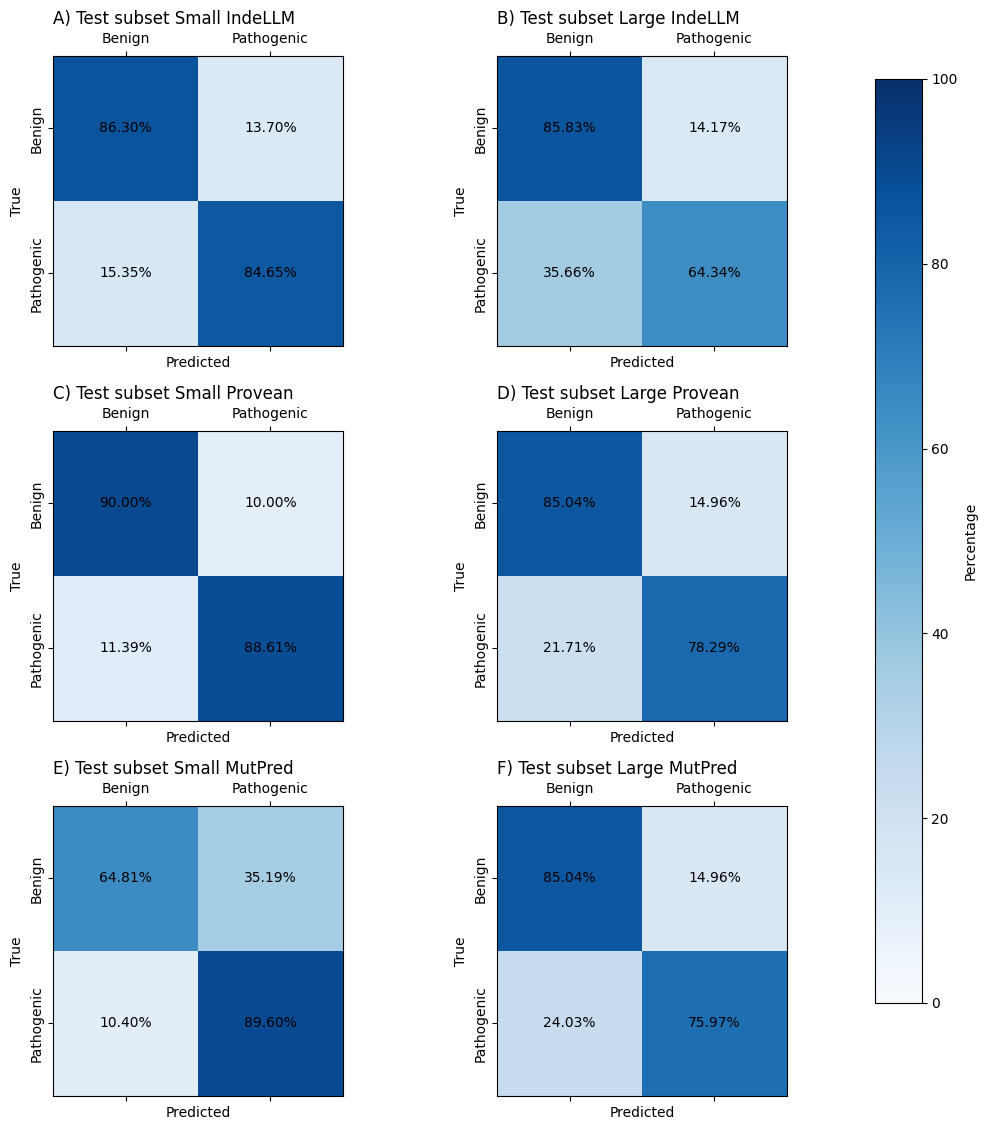

In [36]:
test_small = test[test['indel_length'] <= 2]
test_long = test[test['indel_length'] >= 3]

pred_test_small_IndeLLM = test_small['dif_IndeLLM'].values
pred_test_long_IndeLLM = test_long['dif_IndeLLM'].values
pred_test_small_Provean = test_small['Provean'].values
pred_test_long_Provean = test_long['Provean'].values
pred_test_small_MutPred = test_small['MutPred-Indel'].values
pred_test_long_MutPred = test_long['MutPred-Indel'].values

truelabels_test_small = test_small['label'].values
truelabels_test_long = test_long['label'].values

fpr_test_small_IndeLLM, tpr_test_small_IndeLLM, thersholds_test_small_IndeLLM = metrics.roc_curve(truelabels_test_small, pred_test_small_IndeLLM, pos_label=0)
fpr_test_long_IndeLLM, tpr_test_long_IndeLLM, thersholds_test_long_IndeLLM = metrics.roc_curve(truelabels_test_long, pred_test_long_IndeLLM, pos_label=0)
fpr_test_small_Provean, tpr_test_small_Provean, thersholds_test_small_Provean = metrics.roc_curve(truelabels_test_small, pred_test_small_Provean, pos_label=0)
fpr_test_long_Provean, tpr_test_long_Provean, thersholds_test_long_Provean = metrics.roc_curve(truelabels_test_long, pred_test_long_Provean, pos_label=0)
fpr_test_small_MutPred, tpr_test_small_MutPred, thersholds_test_small_MutPred = metrics.roc_curve(truelabels_test_small, pred_test_small_MutPred, pos_label=1)
fpr_test_long_MutPred, tpr_test_long_MutPred, thersholds_test_long_MutPred = metrics.roc_curve(truelabels_test_long, pred_test_long_MutPred, pos_label=1)

tresh_test_small_IndeLLM = thersholds_test_small_IndeLLM[np.argmax(tpr_test_small_IndeLLM - fpr_test_small_IndeLLM)]
tresh_test_long_IndeLLM = thersholds_test_long_IndeLLM[np.argmax(tpr_test_long_IndeLLM - fpr_test_long_IndeLLM)]
tresh_test_small_Provean = thersholds_test_small_Provean[np.argmax(tpr_test_small_Provean - fpr_test_small_Provean)]
tresh_test_long_Provean = thersholds_test_long_Provean[np.argmax(tpr_test_long_Provean - fpr_test_long_Provean)]
tresh_test_small_MutPred = thersholds_test_small_MutPred[np.argmax(tpr_test_small_MutPred - fpr_test_small_MutPred)]
tresh_test_long_MutPred = thersholds_test_long_MutPred[np.argmax(tpr_test_long_MutPred - fpr_test_long_MutPred)]

pred_test_small_IndeLLM_bin = [0 if x >= tresh_test_small_IndeLLM else 1 for x in pred_test_small_IndeLLM]
pred_test_long_IndeLLM_bin = [0 if x >= tresh_test_long_IndeLLM else 1 for x in pred_test_long_IndeLLM]
pred_test_small_Provean_bin = [0 if x >= tresh_test_small_Provean else 1 for x in pred_test_small_Provean]
pred_test_long_Provean_bin = [0 if x >= tresh_test_long_Provean else 1 for x in pred_test_long_Provean]
pred_test_small_MutPred_bin = [1 if x >= tresh_test_small_MutPred else 0 for x in pred_test_small_MutPred]
pred_test_long_MutPred_bin = [1 if x >= tresh_test_long_MutPred else 0 for x in pred_test_long_MutPred]

confusion_test_small_IndeLLM = confusion_matrix(truelabels_test_small, pred_test_small_IndeLLM_bin)
confusion_test_long_IndeLLM = confusion_matrix(truelabels_test_long, pred_test_long_IndeLLM_bin)
confusion_test_small_Provean = confusion_matrix(truelabels_test_small, pred_test_small_Provean_bin)
confusion_test_long_Provean = confusion_matrix(truelabels_test_long, pred_test_long_Provean_bin)
confusion_test_small_MutPred = confusion_matrix(truelabels_test_small, pred_test_small_MutPred_bin)
confusion_test_long_MutPred = confusion_matrix(truelabels_test_long, pred_test_long_MutPred_bin)

title_test_size = [
    "A) Test subset Small IndeLLM",
    "B) Test subset Large IndeLLM",
    "C) Test subset Small Provean",
    "D) Test subset Large Provean",
    "E) Test subset Small MutPred",
    "F) Test subset Large MutPred"
]

confusions_test_size = [
    confusion_test_small_IndeLLM,
    confusion_test_long_IndeLLM,
    confusion_test_small_Provean,
    confusion_test_long_Provean,
    confusion_test_small_MutPred,
    confusion_test_long_MutPred
]

fig_test_size, axes_test_size = plt.subplots(3, 2, figsize=(12, 12))
for ax, confusion_test_size, title_test_size in zip(axes_test_size.ravel(), confusions_test_size, title_test_size):
    cax_matrix_test_size = plot_percentage_confusion_matrix(confusion_test_size, title_test_size, labels, ax=ax)
fig_test_size.colorbar(cax_matrix_test_size, ax=axes_test_size.ravel().tolist(), orientation='vertical', fraction=0.05, pad=0.05, label='Percentage')
plt.tight_layout(rect=[0, 0, 0.8, 0.95])


### Indel functional association
MutPred-Indel provides a likelihood of functional impact by the indel (REF). 

We import the MutPred-Indel functional association into the test dataset. 

/var/folders/5p/q6ym8f8d30bcrz8gjd8ks42h0000gn/T/ipykernel_10716/2005901863.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.8, 0.95])


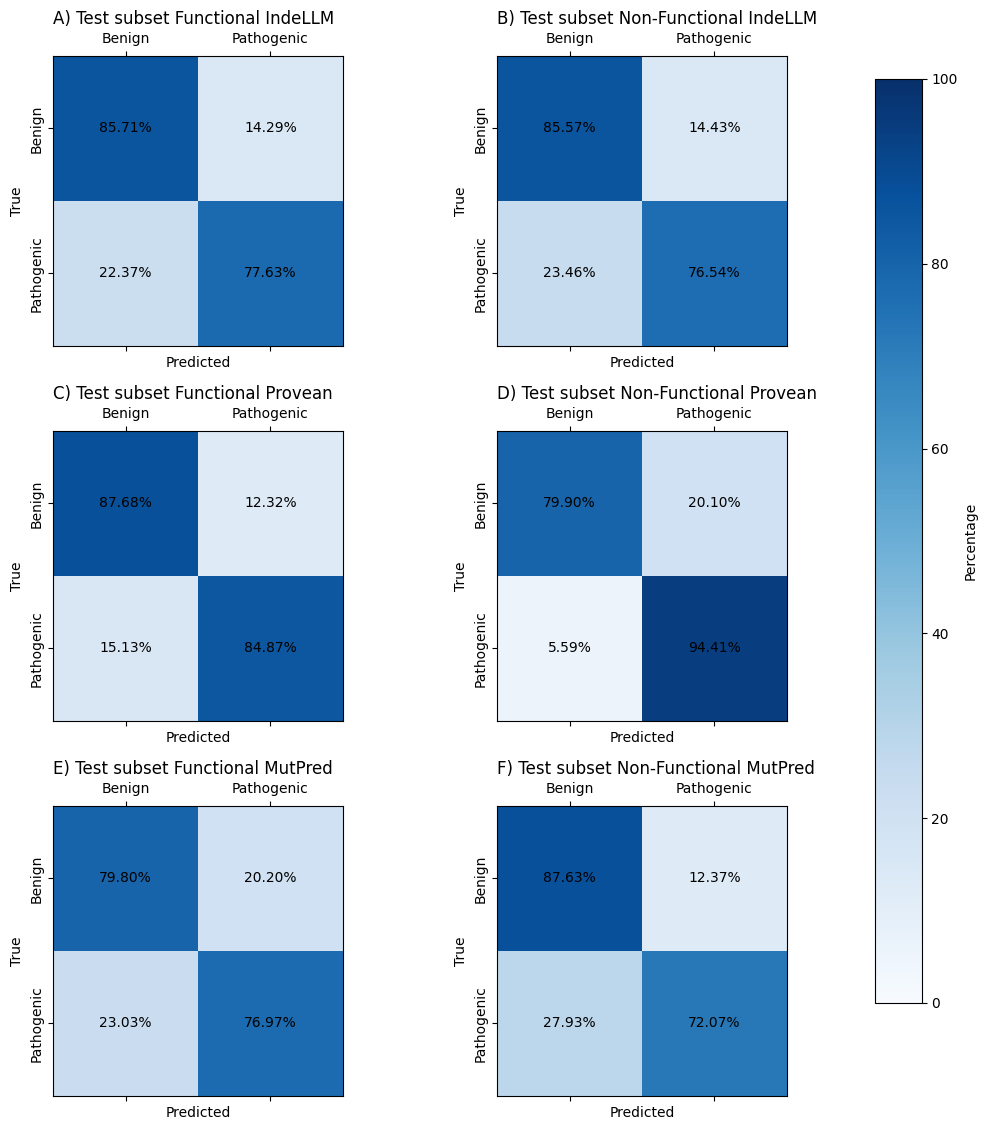

In [37]:
test_func = pd.read_csv('test_func.csv')
test_func['dif_IndeLLM'] = test_func.apply(lambda row: scoresESM2_650M[scoresESM2_650M['id'] == row['id']]['dif_IndeLLM'].values[0], axis=1)

test_func_true = test_func[test_func['functional_sites'] == 1]
test_func_false = test_func[test_func['functional_sites'] == 0]

pred_test_func_true_IndeLLM = test_func_true['dif_IndeLLM'].values
pred_test_func_false_IndeLLM = test_func_false['dif_IndeLLM'].values
pred_test_func_true_Provean = test_func_true['Provean'].values
pred_test_func_false_Provean = test_func_false['Provean'].values
pred_test_func_true_MutPred = test_func_true['MutPred-Indel'].values
pred_test_func_false_MutPred = test_func_false['MutPred-Indel'].values

truelabels_test_func_true = test_func_true['label'].values
truelabels_test_func_false = test_func_false['label'].values

fpr_test_func_true_IndeLLM, tpr_test_func_true_IndeLLM, thersholds_test_func_true_IndeLLM = metrics.roc_curve(truelabels_test_func_true, pred_test_func_true_IndeLLM, pos_label=0)
fpr_test_func_false_IndeLLM, tpr_test_func_false_IndeLLM, thersholds_test_func_false_IndeLLM = metrics.roc_curve(truelabels_test_func_false, pred_test_func_false_IndeLLM, pos_label=0)
fpr_test_func_true_Provean, tpr_test_func_true_Provean, thersholds_test_func_true_Provean = metrics.roc_curve(truelabels_test_func_true, pred_test_func_true_Provean, pos_label=0)
fpr_test_func_false_Provean, tpr_test_func_false_Provean, thersholds_test_func_false_Provean = metrics.roc_curve(truelabels_test_func_false, pred_test_func_false_Provean, pos_label=0)
fpr_test_func_true_MutPred, tpr_test_func_true_MutPred, thersholds_test_func_true_MutPred = metrics.roc_curve(truelabels_test_func_true, pred_test_func_true_MutPred, pos_label=1)
fpr_test_func_false_MutPred, tpr_test_func_false_MutPred, thersholds_test_func_false_MutPred = metrics.roc_curve(truelabels_test_func_false, pred_test_func_false_MutPred, pos_label=1)

tresh_test_func_true_IndeLLM = thersholds_test_func_true_IndeLLM[np.argmax(tpr_test_func_true_IndeLLM - fpr_test_func_true_IndeLLM)]
tresh_test_func_false_IndeLLM = thersholds_test_func_false_IndeLLM[np.argmax(tpr_test_func_false_IndeLLM - fpr_test_func_false_IndeLLM)]
tresh_test_func_true_Provean = thersholds_test_func_true_Provean[np.argmax(tpr_test_func_true_Provean - fpr_test_func_true_Provean)]
tresh_test_func_false_Provean = thersholds_test_func_false_Provean[np.argmax(tpr_test_func_false_Provean - fpr_test_func_false_Provean)]
tresh_test_func_true_MutPred = thersholds_test_func_true_MutPred[np.argmax(tpr_test_func_true_MutPred - fpr_test_func_true_MutPred)]
tresh_test_func_false_MutPred = thersholds_test_func_false_MutPred[np.argmax(tpr_test_func_false_MutPred - fpr_test_func_false_MutPred)]

pred_test_func_true_IndeLLM_bin = [0 if x >= tresh_test_func_true_IndeLLM else 1 for x in pred_test_func_true_IndeLLM]
pred_test_func_false_IndeLLM_bin = [0 if x >= tresh_test_func_false_IndeLLM else 1 for x in pred_test_func_false_IndeLLM]
pred_test_func_true_Provean_bin = [0 if x >= tresh_test_func_true_Provean else 1 for x in pred_test_func_true_Provean]
pred_test_func_false_Provean_bin = [0 if x >= tresh_test_func_false_Provean else 1 for x in pred_test_func_false_Provean]
pred_test_func_true_MutPred_bin = [1 if x >= tresh_test_func_true_MutPred else 0 for x in pred_test_func_true_MutPred]
pred_test_func_false_MutPred_bin = [1 if x >= tresh_test_func_false_MutPred else 0 for x in pred_test_func_false_MutPred]

confusion_test_func_true_IndeLLM = confusion_matrix(truelabels_test_func_true, pred_test_func_true_IndeLLM_bin)
confusion_test_func_false_IndeLLM = confusion_matrix(truelabels_test_func_false, pred_test_func_false_IndeLLM_bin)
confusion_test_func_true_Provean = confusion_matrix(truelabels_test_func_true, pred_test_func_true_Provean_bin)
confusion_test_func_false_Provean = confusion_matrix(truelabels_test_func_false, pred_test_func_false_Provean_bin)
confusion_test_func_true_MutPred = confusion_matrix(truelabels_test_func_true, pred_test_func_true_MutPred_bin)
confusion_test_func_false_MutPred = confusion_matrix(truelabels_test_func_false, pred_test_func_false_MutPred_bin)

titles_test_func = [
    "A) Test subset Functional IndeLLM",
    "B) Test subset Non-Functional IndeLLM",
    "C) Test subset Functional Provean",
    "D) Test subset Non-Functional Provean",
    "E) Test subset Functional MutPred",
    "F) Test subset Non-Functional MutPred"
]

confusions_test_func = [
    confusion_test_func_true_IndeLLM,
    confusion_test_func_false_IndeLLM,
    confusion_test_func_true_Provean,
    confusion_test_func_false_Provean,
    confusion_test_func_true_MutPred,
    confusion_test_func_false_MutPred
]

fig_test_func, axes_test_func = plt.subplots(3, 2, figsize=(12, 12))
for ax, confusion_test_func, title_test_func in zip(axes_test_func.ravel(), confusions_test_func, titles_test_func):
    cax_matrix_test_func = plot_percentage_confusion_matrix(confusion_test_func, title_test_func, labels, ax=ax)
fig_test_func.colorbar(cax_matrix_test_func, ax=axes_test_func.ravel().tolist(), orientation='vertical', fraction=0.05, pad=0.05, label='Percentage')
plt.tight_layout(rect=[0, 0, 0.8, 0.95])


# 4.3 Comparing Transformer based models for Indel representation
We compared 6 PLMs using the IndeLLM scoring approach.   
We evaluate the performace of the scoring approaches by calculation of false and true positives, AUC, F1-score and MCC.

In [38]:
#Add difference of fitness (positive value positive effect, negative value negative effect)
scoresESM1b['dif_IndeLLM'] = scoresESM1b['IndeLLM_mut'] - scoresESM1b['IndeLLM_wt']
scoresESM1v['dif_IndeLLM'] = scoresESM1v['IndeLLM_mut'] - scoresESM1v['IndeLLM_wt']
scoresESM2_3B['dif_IndeLLM'] = scoresESM2_3B['IndeLLM_mut'] - scoresESM2_3B['IndeLLM_wt']
scoresESM2_150M['dif_IndeLLM'] = scoresESM2_150M['IndeLLM_mut'] - scoresESM2_150M['IndeLLM_wt']
scoresESM3['dif_IndeLLM'] = scoresESM3['IndeLLM_mut'] - scoresESM3['IndeLLM_wt']
scoresProtTrans['dif_IndeLLM'] = scoresProtTrans['IndeLLM_mut'] - scoresProtTrans['IndeLLM_wt']

#Our predictors, differenct PLMs and scoreing types
pred_ESM1b_IndeLLM = scoresESM1b['dif_IndeLLM'].values
pred_ESM1v_IndeLLM = scoresESM1v['dif_IndeLLM'].values
pred_ESM23b_IndeLLM = scoresESM2_3B['dif_IndeLLM'].values
pred_ESM2150M_IndeLLM = scoresESM2_150M['dif_IndeLLM'].values
pred_ESM3_IndeLLM = scoresESM3['dif_IndeLLM'].values
pred_ProtTrans_IndeLLM = scoresProtTrans['dif_IndeLLM'].values

#Calculating ture and false positive rates 
fpr_ESM1b_IndeLLM, tpr_ESM1b_IndeLLM, thersholds_ESM1b_IndeLLM = metrics.roc_curve(truelabels_alldata, pred_ESM1b_IndeLLM, pos_label=0)
fpr_ESM1v_IndeLLM, tpr_ESM1v_IndeLLM, thersholds_ESM1v_IndeLLM = metrics.roc_curve(truelabels_alldata, pred_ESM1v_IndeLLM, pos_label=0)
fpr_ESM23b_IndeLLM, tpr_ESM23b_IndeLLM, thersholds_ESM23b_IndeLLM = metrics.roc_curve(truelabels_alldata, pred_ESM23b_IndeLLM, pos_label=0)
fpr_ESM2150M_IndeLLM, tpr_ESM2150M_IndeLLM, thersholds_ESM2150M_IndeLLM = metrics.roc_curve(truelabels_alldata, pred_ESM2150M_IndeLLM, pos_label=0)
fpr_ESM3_IndeLLM, tpr_ESM3_IndeLLM, thersholds_ESM3_IndeLLM = metrics.roc_curve(truelabels_alldata, pred_ESM3_IndeLLM, pos_label=0)
fpr_ProtTrans_IndeLLM, tpr_ProtTrans_IndeLLM, thersholds_ProtTrans_IndeLLM = metrics.roc_curve(truelabels_alldata, pred_ProtTrans_IndeLLM, pos_label=0)

roc_auc_ESM1b_IndeLLM = round(metrics.auc(fpr_ESM1b_IndeLLM, tpr_ESM1b_IndeLLM), 2)
roc_auc_ESM1v_IndeLLM = round(metrics.auc(fpr_ESM1v_IndeLLM, tpr_ESM1v_IndeLLM), 2)
roc_auc_ESM23b_IndeLLM = round(metrics.auc(fpr_ESM23b_IndeLLM, tpr_ESM23b_IndeLLM), 2)
roc_auc_ESM2150M_IndeLLM = round(metrics.auc(fpr_ESM2150M_IndeLLM, tpr_ESM2150M_IndeLLM), 2)
roc_auc_ESM3_IndeLLM = round(metrics.auc(fpr_ESM3_IndeLLM, tpr_ESM3_IndeLLM), 2)
roc_auc_ProtTrans_IndeLLM = round(metrics.auc(fpr_ProtTrans_IndeLLM, tpr_ProtTrans_IndeLLM), 2)

tresh_ESM1b_IndeLLM = thersholds_ESM1b_IndeLLM[np.argmax(tpr_ESM1b_IndeLLM - fpr_ESM1b_IndeLLM)]
tresh_ESM1v_IndeLLM = thersholds_ESM1v_IndeLLM[np.argmax(tpr_ESM1v_IndeLLM - fpr_ESM1v_IndeLLM)]
tresh_ESM23b_IndeLLM = thersholds_ESM23b_IndeLLM[np.argmax(tpr_ESM23b_IndeLLM - fpr_ESM23b_IndeLLM)]
tresh_ESM2150M_IndeLLM = thersholds_ESM2150M_IndeLLM[np.argmax(tpr_ESM2150M_IndeLLM - fpr_ESM2150M_IndeLLM)]
tresh_ESM3_IndeLLM = thersholds_ESM3_IndeLLM[np.argmax(tpr_ESM3_IndeLLM - fpr_ESM3_IndeLLM)]
tresh_ProtTrans_IndeLLM = thersholds_ProtTrans_IndeLLM[np.argmax(tpr_ProtTrans_IndeLLM - fpr_ProtTrans_IndeLLM)]

pred_ESM1b_IndeLLM_bin = [0 if x >= tresh_ESM1b_IndeLLM else 1 for x in pred_ESM1b_IndeLLM]
pred_ESM1v_IndeLLM_bin = [0 if x >= tresh_ESM1v_IndeLLM else 1 for x in pred_ESM1v_IndeLLM]
pred_ESM23b_IndeLLM_bin = [0 if x >= tresh_ESM23b_IndeLLM else 1 for x in pred_ESM23b_IndeLLM]
pred_ESM2150M_IndeLLM_bin = [0 if x >= tresh_ESM2150M_IndeLLM else 1 for x in pred_ESM2150M_IndeLLM]
pred_ESM3_IndeLLM_bin = [0 if x >= tresh_ESM3_IndeLLM else 1 for x in pred_ESM3_IndeLLM]
pred_ProtTrans_IndeLLM_bin = [0 if x >= tresh_ProtTrans_IndeLLM else 1 for x in pred_ProtTrans_IndeLLM]

f1_ESM1b_IndeLLM = f1_score(truelabels_alldata, pred_ESM1b_IndeLLM_bin, average = 'binary', pos_label=0)
f1_ESM1v_IndeLLM = f1_score(truelabels_alldata, pred_ESM1v_IndeLLM_bin, average = 'binary', pos_label=0)
f1_ESM23b_IndeLLM = f1_score(truelabels_alldata, pred_ESM23b_IndeLLM_bin, average = 'binary', pos_label=0)
f1_ESM2150M_IndeLLM = f1_score(truelabels_alldata, pred_ESM2150M_IndeLLM_bin, average = 'binary', pos_label=0)
f1_ESM3_IndeLLM = f1_score(truelabels_alldata, pred_ESM3_IndeLLM_bin, average = 'binary', pos_label=0)
f1_ProtTrans_IndeLLM = f1_score(truelabels_alldata, pred_ProtTrans_IndeLLM_bin, average = 'binary', pos_label=0)

mcc_ESM1b_IndeLLM = matthews_corrcoef(truelabels_alldata, pred_ESM1b_IndeLLM_bin)
mcc_ESM1v_IndeLLM = matthews_corrcoef(truelabels_alldata, pred_ESM1v_IndeLLM_bin)
mcc_ESM23b_IndeLLM = matthews_corrcoef(truelabels_alldata, pred_ESM23b_IndeLLM_bin)
mcc_ESM2150M_IndeLLM = matthews_corrcoef(truelabels_alldata, pred_ESM2150M_IndeLLM_bin)
mcc_ESM3_IndeLLM = matthews_corrcoef(truelabels_alldata, pred_ESM3_IndeLLM_bin)
mcc_ProtTrans_IndeLLM = matthews_corrcoef(truelabels_alldata, pred_ProtTrans_IndeLLM_bin)

# Plotting of Figure 3A-3B

/var/folders/5p/q6ym8f8d30bcrz8gjd8ks42h0000gn/T/ipykernel_10716/3798482807.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(fontsize = 8, frameon=False)


Text(0.0, 1.0, 'B) MCC scores for PLMs')

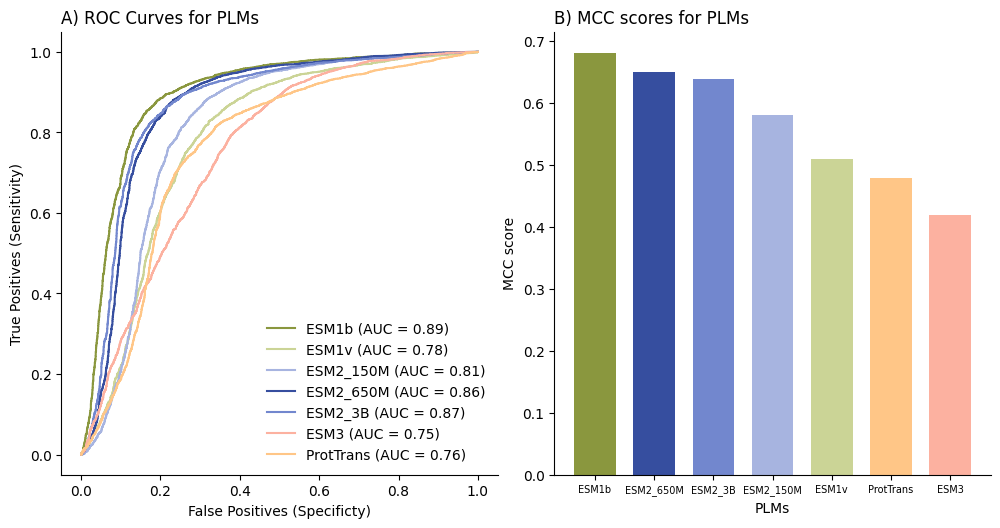

In [39]:

allPLMS = {'PLMs': ['ESM1b', 'ESM1v', 'ESM2_150M', 'ESM2_650M', 'ESM2_3B', 'ESM3', 'ProtTrans'], 
                 'F1': [f1_ESM1b_IndeLLM, f1_ESM1v_IndeLLM, f1_ESM2150M_IndeLLM,  f1_ESM2650M_IndeLLM, f1_ESM23b_IndeLLM, f1_ESM3_IndeLLM, f1_ProtTrans_IndeLLM], 
                 'MCC': [mcc_ESM1b_IndeLLM, mcc_ESM1v_IndeLLM, mcc_ESM2150M_IndeLLM,  mcc_ESM2650M_IndeLLM, mcc_ESM23b_IndeLLM, mcc_ESM3_IndeLLM, mcc_ProtTrans_IndeLLM], 
                 'AUC': [roc_auc_ESM1b_IndeLLM, roc_auc_ESM1v_IndeLLM, roc_auc_ESM2150M_IndeLLM,  roc_auc_ESM2650M_IndeLLM, roc_auc_ESM23b_IndeLLM, roc_auc_ESM3_IndeLLM, roc_auc_ProtTrans_IndeLLM]}
allPLMS = pd.DataFrame(allPLMS)
allPLMS = allPLMS.sort_values('MCC', ascending=False)
allPLMS = allPLMS.reset_index(drop=True)

colors = {
    'ESM2_150M': '#a7b4e0',
    'ESM2_650M': '#364e9f',
    'ESM2_3B': '#7287ce',
    'ESM3': '#FCB1A0',
    'ProtTrans': '#FFC687',
    'ESM1b': '#8a973e',
    'ESM1v': '#CBD496'
}

n_methods = len(allPLMS['PLMs'])
bar_width = 0.7
r1 = np.arange(n_methods)
r2 = [x + bar_width for x in r1]

f, axes = plt.subplots(1,2)
f.set_figheight(5)
f.set_figwidth(10)
f.tight_layout(pad=1)

axes[0].plot(fpr_ESM1b_IndeLLM, tpr_ESM1b_IndeLLM, label = "ESM1b (AUC = "+str(roc_auc_ESM1b_IndeLLM)+")", color = "#8a973e")
axes[0].plot(fpr_ESM1v_IndeLLM, tpr_ESM1v_IndeLLM, label = "ESM1v (AUC = "+str(roc_auc_ESM1v_IndeLLM)+")", color = "#CBD496")
axes[0].plot(fpr_ESM2150M_IndeLLM, tpr_ESM2150M_IndeLLM, label = "ESM2_150M (AUC = "+str(roc_auc_ESM2150M_IndeLLM)+")", color = "#a7b4e0")
axes[0].plot(fpr_ESM2650M_IndeLLM, tpr_ESM2650M_IndeLLM, label = "ESM2_650M (AUC = "+str(roc_auc_ESM2650M_IndeLLM)+")", color = "#364e9f")
axes[0].plot(fpr_ESM23b_IndeLLM, tpr_ESM23b_IndeLLM, label = "ESM2_3B (AUC = "+str(roc_auc_ESM23b_IndeLLM)+")", color = "#7287ce")
axes[0].plot(fpr_ESM3_IndeLLM, tpr_ESM3_IndeLLM, label = "ESM3 (AUC = "+str(roc_auc_ESM3_IndeLLM)+")", color = "#FCB1A0")
axes[0].plot(fpr_ProtTrans_IndeLLM, tpr_ProtTrans_IndeLLM, label = "ProtTrans (AUC = "+str(roc_auc_ProtTrans_IndeLLM)+")", color = "#FFC687")
axes[0].set_xlabel('False Positives (Specificty)')
axes[0].set_ylabel('True Positives (Sensitivity)')
axes[0].set_title("A) ROC Curves for PLMs", loc = 'left')
axes[0].legend(loc = 'best', frameon=False)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[1].bar(r1, allPLMS['MCC'], color=[colors[score] for score in allPLMS['PLMs']], width=bar_width)
axes[1].set_ylabel('MCC score')
axes[1].set_xlabel('PLMs')
axes[1].set_xticks(r1, allPLMS['PLMs'], fontsize = 7)
axes[1].legend(fontsize = 8, frameon=False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_title('B) MCC scores for PLMs', loc = 'left')